
# Project: Fraud Detection —  Transaction Evaluation
# File required: transactional-sample.csv


In [130]:
from google.colab import files
uploaded = files.upload()


Saving transactional-sample.csv to transactional-sample.csv


In [131]:
import io, pandas as pd
def read_csv_best_effort(fname):
    try:
        return pd.read_csv(io.BytesIO(uploaded[fname]), sep=None, engine="python")
    except Exception:
        pass
    try:
        return pd.read_csv(io.BytesIO(uploaded[fname]))
    except Exception:
        pass
    # 3) Try whitespace-delimited
    return pd.read_csv(io.BytesIO(uploaded[fname]), sep=r"\s+", engine="python")

df = read_csv_best_effort("transactional-sample.csv")
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [132]:

import numpy as np

df.columns = [c.strip() for c in df.columns]

if 'transaction_date' in df.columns:
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

if 'has_cbk' in df.columns:
    df['has_cbk'] = df['has_cbk'].astype(str).str.upper().isin(['TRUE','T','1'])

if 'transaction_amount' in df.columns:
    df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce')

if 'device_id' in df.columns:
    # leave NaNs as-is, convert others to Int64 to avoid 497105.0 style
    try:
        df['device_id'] = df['device_id'].astype('Int64')
    except Exception:
        pass

print(df.head())
print(df.info())

num_summary = df.select_dtypes(include=[np.number]).describe()
print(num_summary)

if 'has_cbk' in df.columns:
    print("Overall chargeback rate:", float(df['has_cbk'].mean()))


   transaction_id  merchant_id  user_id       card_number  \
0        21320398        29744    97051  434505******9116   
1        21320399        92895     2708  444456******4210   
2        21320400        47759    14777  425850******7024   
3        21320401        68657    69758  464296******3991   
4        21320402        54075    64367  650487******6116   

            transaction_date  transaction_amount  device_id  has_cbk  
0 2019-12-01 23:16:32.812632              374.56     285475    False  
1 2019-12-01 22:45:37.873639              734.87     497105     True  
2 2019-12-01 22:22:43.021495              760.36       <NA>    False  
3 2019-12-01 21:59:19.797129             2556.13       <NA>     True  
4 2019-12-01 21:30:53.347051               55.36     860232    False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  ----

#**Transaction Overview:**

The dataset has 3,199 transactions in total.

Count = 3199 → all transactions have an amount.

Mean ≈ 767.8 → the average transaction is around 768.

Median (50%) ≈ 415.9 → half of all transactions are below 416.

Std dev ≈ 889.1 → large variation, some transactions are much higher than average.

Min = 1.22 → probably test or micro-purchase.

Max = 4097.21 → high-value purchase, possibly high-risk.


*   The gap between the mean (768) and median (416) shows a right-skewed distribution. A few big-value transactions pull up the average. This is typical of card payments, but also relevant because fraudsters often prefer higher amounts once they confirm a stolen card works.
*   Roughly 2,369 unique devices across 3,199 transactions.

*   12.22% of all transactions were charged back.That’s very high in real payment environments, normal is <1%; even 2–3% triggers network penalties (e.g., Visa/Mastercard fines).So, dataset is a high-risk portfolio


In [133]:
#  Grouped views (users, devices, merchants)

import numpy as np
import pandas as pd

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce')
df['has_cbk'] = df['has_cbk'].astype(bool)
if 'device_id' in df.columns:
    try:
        df['device_id'] = df['device_id'].astype('Int64')
    except Exception:
        pass

if 'user_tx_10m' not in df.columns:
    helper = df[['user_id','transaction_id','transaction_date']].copy().set_index('transaction_date')
    rolled = (helper.groupby('user_id')['transaction_id']
              .rolling('10min').count()
              .rename('user_tx_10m')
              .reset_index())
    df = df.merge(rolled, on=['user_id','transaction_date'], how='left')

if ('device_id' in df.columns) and ('device_tx_10m' not in df.columns):
    df_dev = df.dropna(subset=['device_id']).copy()
    helper_d = df_dev[['device_id','transaction_id','transaction_date']].set_index('transaction_date')
    rolled_d = (helper_d.groupby('device_id')['transaction_id']
                .rolling('10min').count()
                .rename('device_tx_10m')
                .reset_index())
    df = df.merge(rolled_d, on=['device_id','transaction_date'], how='left')

mad = lambda s: float((s - s.median()).abs().median()) if s.notna().sum() else np.nan
iqr = lambda s: float(s.quantile(0.75) - s.quantile(0.25)) if s.notna().sum() else np.nan
p95 = lambda s: float(s.quantile(0.95)) if s.notna().sum() else np.nan
share = lambda s: float(np.mean(s)) if len(s) else np.nan


P95 = df['transaction_amount'].quantile(0.95) if df['transaction_amount'].notna().any() else 2000.0
HIGH_TICKET = max(2000.0, float(P95))

#  BY USER

by_user = (df
    .groupby('user_id', dropna=False)
    .agg(
        tx_count=('transaction_id','count'),
        cbk_count=('has_cbk','sum'),
        cbk_rate=('has_cbk','mean'),
        total_amt=('transaction_amount','sum'),
        mean_amt=('transaction_amount','mean'),
        median_amt=('transaction_amount','median'),
        std_amt=('transaction_amount','std'),
        min_amt=('transaction_amount','min'),
        max_amt=('transaction_amount','max'),
        max_user_tx_10m=('user_tx_10m','max'),
        first_tx=('transaction_date','min'),
        last_tx=('transaction_date','max'),
        distinct_merchants=('merchant_id','nunique'),
        distinct_cards=('card_number','nunique') if 'card_number' in df.columns else ('transaction_id','count'),
        distinct_devices=('device_id','nunique') if 'device_id' in df.columns else ('transaction_id','count'),
    )
)

by_user = by_user.assign(
    p95_amt = df.groupby('user_id')['transaction_amount'].apply(p95),
    iqr_amt = df.groupby('user_id')['transaction_amount'].apply(iqr),
    mad_amt = df.groupby('user_id')['transaction_amount'].apply(mad),
    high_ticket_share = df.groupby('user_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),
)
by_user['active_minutes'] = (by_user['last_tx'] - by_user['first_tx']).dt.total_seconds()/60.0

by_user_suspicious = by_user.sort_values(
    ['cbk_rate','tx_count','high_ticket_share','max_user_tx_10m'],
    ascending=[False, False, False, False]
)


# BY DEVICE

if 'device_id' in df.columns:
    dev_df = df.dropna(subset=['device_id']).copy()

    by_device = (dev_df
        .groupby('device_id', dropna=False)
        .agg(
            tx_count=('transaction_id','count'),
            cbk_count=('has_cbk','sum'),
            cbk_rate=('has_cbk','mean'),
            total_amt=('transaction_amount','sum'),
            mean_amt=('transaction_amount','mean'),
            median_amt=('transaction_amount','median'),
            std_amt=('transaction_amount','std'),
            min_amt=('transaction_amount','min'),
            max_amt=('transaction_amount','max'),
            max_device_tx_10m=('device_tx_10m','max') if 'device_tx_10m' in dev_df.columns else ('transaction_id','count'),
            distinct_users=('user_id','nunique'),
            distinct_merchants=('merchant_id','nunique'),
            distinct_cards=('card_number','nunique') if 'card_number' in dev_df.columns else ('transaction_id','count'),
            first_tx=('transaction_date','min'),
            last_tx=('transaction_date','max'),
        )
    ).assign(
        p95_amt = dev_df.groupby('device_id')['transaction_amount'].apply(p95),
        iqr_amt = dev_df.groupby('device_id')['transaction_amount'].apply(iqr),
        mad_amt = dev_df.groupby('device_id')['transaction_amount'].apply(mad),
        high_ticket_share = dev_df.groupby('device_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),
    )
    by_device['active_minutes'] = (by_device['last_tx'] - by_device['first_tx']).dt.total_seconds()/60.0

    by_device_suspicious = by_device.sort_values(
        ['cbk_rate','tx_count','distinct_users','high_ticket_share','max_device_tx_10m'],
        ascending=[False, False, False, False, False]
    )
else:
    by_device = None
    by_device_suspicious = None


# BY MERCHANT

by_merchant = (df
    .groupby('merchant_id', dropna=False)
    .agg(
        tx_count=('transaction_id','count'),
        cbk_count=('has_cbk','sum'),
        cbk_rate=('has_cbk','mean'),
        total_amt=('transaction_amount','sum'),
        mean_amt=('transaction_amount','mean'),
        median_amt=('transaction_amount','median'),
        std_amt=('transaction_amount','std'),
        min_amt=('transaction_amount','min'),
        max_amt=('transaction_amount','max'),
        distinct_users=('user_id','nunique'),
        distinct_devices=('device_id','nunique') if 'device_id' in df.columns else ('transaction_id','count'),
        distinct_cards=('card_number','nunique') if 'card_number' in df.columns else ('transaction_id','count'),
        first_tx=('transaction_date','min'),
        last_tx=('transaction_date','max'),
    )
).assign(
    p95_amt = df.groupby('merchant_id')['transaction_amount'].apply(p95),
    iqr_amt = df.groupby('merchant_id')['transaction_amount'].apply(iqr),
    mad_amt = df.groupby('merchant_id')['transaction_amount'].apply(mad),
    high_ticket_share = df.groupby('merchant_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),
)
by_merchant['active_minutes'] = (by_merchant['last_tx'] - by_merchant['first_tx']).dt.total_seconds()/60.0

by_merchant_suspicious = by_merchant.sort_values(
    ['cbk_rate','tx_count','distinct_users','high_ticket_share'],
    ascending=[False, False, False, False]
)

print("Baseline CBK rate:", float(df['has_cbk'].mean()))
print("\nTop suspicious USERS:")
display(by_user_suspicious.head(10))

if by_device_suspicious is not None:
    print("\nTop suspicious DEVICES:")
    display(by_device_suspicious.head(10))

print("\nTop suspicious MERCHANTS:")
display(by_merchant_suspicious.head(10))


/tmp/ipython-input-3511636727.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_ticket_share = df.groupby('user_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),
/tmp/ipython-input-3511636727.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_ticket_share = dev_df.groupby('device_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),


Baseline CBK rate: 0.12222569552985307

Top suspicious USERS:


/tmp/ipython-input-3511636727.py:143: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_ticket_share = df.groupby('merchant_id').apply(lambda g: share(g['transaction_amount'] >= HIGH_TICKET)),


,tx_count,cbk_count,cbk_rate,total_amt,mean_amt,median_amt,std_amt,min_amt,max_amt,max_user_tx_10m,first_tx,last_tx,distinct_merchants,distinct_cards,distinct_devices,p95_amt,iqr_amt,mad_amt,high_ticket_share,active_minutes
user_id,,,,,,,,,,,,,,,,,,,,
75710,10,10,1.0,5613.81,561.381000,507.125,398.900485,254.25,1631.24,6.0,2019-11-08 23:05:13.814924,2019-11-09 20:11:57.306777,1,1,0,1166.7905,247.6625,106.155,0.000000,1266.724864
7725,7,7,1.0,10822.94,1546.134286,1576.680,994.399033,10.14,2594.59,2.0,2019-11-28 16:01:04.989041,2019-12-01 19:22:45.419831,1,5,2,2576.4250,1306.0650,957.360,0.000000,4521.673846
17929,6,6,1.0,21840.69,3640.115000,3963.440,732.825218,2201.48,4095.82,1.0,2019-11-22 22:13:42.283571,2019-11-28 22:20:04.236179,2,6,1,4086.5175,421.4275,113.775,0.833333,8646.365877
21768,6,6,1.0,5152.61,858.768333,993.695,337.649459,170.69,1018.48,2.0,2019-11-30 15:02:01.356559,2019-12-01 16:55:55.203125,2,1,1,1016.9000,39.4850,21.625,0.000000,1553.897443
99396,5,5,1.0,10059.33,2011.866000,2559.250,1325.264945,471.94,3627.51,1.0,2019-11-29 21:43:15.235182,2019-11-30 16:09:53.763866,1,5,3,3418.1320,1760.6100,1068.260,0.200000,1106.642145
28218,5,5,1.0,2966.17,593.234000,426.840,341.348985,280.24,1084.91,2.0,2019-11-18 16:03:21.232777,2019-11-21 20:57:57.646829,1,2,1,1029.7540,444.0800,146.600,0.000000,4614.606901
71424,5,5,1.0,2966.74,593.348000,569.460,97.381837,501.10,728.66,2.0,2019-11-28 14:43:41.301090,2019-11-30 00:01:19.082265,1,3,2,714.0740,143.9400,68.360,0.000000,1997.629686
86411,5,5,1.0,7975.64,1595.128000,1952.180,815.224110,140.38,2030.64,1.0,2019-11-21 21:37:35.783765,2019-11-27 19:51:00.783741,1,1,1,2020.4040,106.4800,78.460,0.000000,8533.416666
76819,4,4,1.0,6175.66,1543.915000,1548.585,408.924902,1038.47,2040.02,4.0,2019-11-03 16:08:01.904202,2019-11-03 16:11:02.048688,1,1,0,1966.7825,255.1650,247.310,0.000000,3.002408



Top suspicious DEVICES:


,tx_count,cbk_count,cbk_rate,total_amt,mean_amt,median_amt,std_amt,min_amt,max_amt,max_device_tx_10m,distinct_users,distinct_merchants,distinct_cards,first_tx,last_tx,p95_amt,iqr_amt,mad_amt,high_ticket_share,active_minutes
device_id,,,,,,,,,,,,,,,,,,,,
960729,6,6,1.0,21840.69,3640.115000,3963.440,732.825218,2201.48,4095.82,1.0,1,2,6,2019-11-22 22:13:42.283571,2019-11-28 22:20:04.236179,4086.5175,421.4275,113.775,0.833333,8646.365877
357277,6,6,1.0,5152.61,858.768333,993.695,337.649459,170.69,1018.48,2.0,1,2,1,2019-11-30 15:02:01.356559,2019-12-01 16:55:55.203125,1016.9000,39.4850,21.625,0.000000,1553.897443
174844,5,5,1.0,2966.17,593.234000,426.840,341.348985,280.24,1084.91,2.0,1,1,2,2019-11-18 16:03:21.232777,2019-11-21 20:57:57.646829,1029.7540,444.0800,146.600,0.000000,4614.606901
308950,5,5,1.0,6665.06,1333.012000,1576.680,1073.116650,10.14,2534.04,2.0,1,1,4,2019-11-28 16:01:04.989041,2019-12-01 19:22:45.419831,2445.7900,1641.3800,957.360,0.000000,4521.673846
597308,5,5,1.0,7975.64,1595.128000,1952.180,815.224110,140.38,2030.64,1.0,1,1,1,2019-11-21 21:37:35.783765,2019-11-27 19:51:00.783741,2020.4040,106.4800,78.460,0.000000,8533.416666
486,4,4,1.0,919.99,229.997500,267.180,151.685923,32.86,352.77,2.0,1,1,2,2019-12-01 20:36:55.091278,2019-12-01 21:24:05.608374,351.7065,197.7275,82.045,0.000000,47.175285
122092,4,4,1.0,2299.96,574.990000,557.505,398.384823,159.21,1025.74,2.0,1,1,1,2019-11-19 23:20:43.187446,2019-11-22 00:12:45.946894,988.9570,551.1550,310.655,0.000000,2932.045991
288714,4,4,1.0,2242.63,560.657500,551.755,47.327202,515.49,623.63,2.0,1,1,2,2019-11-28 23:41:18.281921,2019-11-30 20:24:00.906638,615.3485,52.0325,26.465,0.000000,2682.710412
822562,4,4,1.0,2572.24,643.060000,673.915,337.993211,202.92,1021.49,2.0,1,1,1,2019-11-24 20:52:53.378276,2019-11-27 21:54:53.282552,975.9620,270.7250,195.815,0.000000,4381.998405



Top suspicious MERCHANTS:


,tx_count,cbk_count,cbk_rate,total_amt,mean_amt,median_amt,std_amt,min_amt,max_amt,distinct_users,distinct_devices,distinct_cards,first_tx,last_tx,p95_amt,iqr_amt,mad_amt,high_ticket_share,active_minutes
merchant_id,,,,,,,,,,,,,,,,,,,
1308,15,15,1.0,34517.94,2301.196000,2259.990,346.137661,1648.30,2904.60,2,2,8,2019-11-29 02:02:30.874661,2019-11-29 17:49:01.844537,2845.0930,286.6450,152.290,0.133333,946.516165
44927,11,11,1.0,9218.62,838.056364,963.890,251.390380,202.92,1021.49,3,3,4,2019-11-24 20:52:53.378276,2019-11-30 15:54:15.929622,1019.9850,265.3250,54.590,0.000000,8341.375856
73271,10,10,1.0,14577.57,1457.757000,1569.985,981.823789,10.14,2594.59,3,4,8,2019-11-28 16:01:04.989041,2019-12-01 19:22:45.419831,2576.4730,1866.4425,974.200,0.000000,4521.673846
38337,6,6,1.0,7579.18,1263.196667,1170.140,542.659974,608.00,2090.41,3,3,3,2019-11-22 17:56:43.858222,2019-11-22 22:41:36.534791,1981.5400,652.4025,384.685,0.000000,284.877943
75917,6,6,1.0,15585.84,2597.640000,2879.690,1535.388701,588.60,4095.82,2,2,5,2019-11-21 22:45:26.226471,2019-11-23 20:03:13.992518,4086.5175,2570.4900,1197.525,0.500000,2717.796101
48126,6,6,1.0,6326.83,1054.471667,1061.515,28.940872,1012.42,1086.37,2,2,2,2019-11-28 23:54:26.320757,2019-11-29 21:09:39.628804,1083.4100,39.4100,18.935,0.000000,1275.221801
81795,6,6,1.0,3392.24,565.373333,567.700,37.706558,515.49,623.63,2,2,3,2019-11-28 23:41:18.281921,2019-12-01 01:07:42.861959,613.3800,36.0150,23.770,0.000000,2966.409667
8942,5,5,1.0,8255.58,1651.116000,1551.770,427.638812,1038.47,2079.92,2,0,2,2019-11-03 16:08:01.904202,2019-11-03 17:02:15.187624,2071.9400,494.6200,488.250,0.000000,54.221390
15326,5,5,1.0,7333.26,1466.652000,1352.340,346.612536,1177.77,2029.63,2,2,3,2019-11-29 22:33:14.606830,2019-11-30 17:47:53.066082,1934.0200,329.6400,174.570,0.000000,1154.640988


#**User-level Insights**:

*   All top 10 users have a cbk_rate = 1.0: These users had chargebacks on every  transaction, meaning 100% fraud likelihood.

*  Transaction count ranges from 4 to 10: Indicates they are active repeat offenders, not single random frauds.

*  Mean of transaction is often above 500 to 3,000, and maximum up to 4,000+: Meaning high-value targeting, possibly testing stolen cards on smaller merchants before going bigger.

*   STD, IQR, and MAD of transaction are vary widely: Fraudsters are not consistent; they vary purchase amounts to avoid detection based on fixed rules (like “flag all transactions >$1,000”).

*   High ticket share is equal to 0 for most: They avoid hitting the top 5% or extreme limits, subtle “camouflage” behavior. Only one user (17929) has 0.83 (≈83% of their transactions are high-ticket). This might be a greedy fraudster.

* Active minutes vary from a few minutes (3.0) to multiple days (~8,500 minutes ≈ 6 days), Suggests mixed patterns: Some perform “fast bursts”  like card testing / bot-driven, others conduct longer fraud campaigns.

* Distinct_merchants, devices, cards, users touch multiple merchants/devices:
These are red flasg for multi-merchant exploitation or synthetic identity networks reusing the same device or cards.


#*Fraud story_User-level:*

*   User 17929 → 6 transactions, all chargebacks, high avg amount (≈$3,640), high-ticket share 83%, single device, few merchants → classic “high-value targeted fraud”.

*  Users like 75710, 7725 → moderate-value, 100% CBK rate, used several cards or devices → possible account takeover or mule accounts.



#**Device-level Insights:**

*  All top devices have cbk_rate = 1.0: Every transaction from these devices resulted in a chargeback → devices are compromised or synthetic.

*   Transaction count ranges 4 to 6 and distinct_users 1 to 3: Devices are often reused by multiple fraudulent users, indicating "shared device signatures".

* STD, IQR, and MAD are moderate → 300 to 1000: Suggests that fraudsters test within a comfortable band of amounts.

*   Maximum device transaction in 10m  is up to 2 → Devices rarely make more than 2 tx in 10 min, Indicates slow fraud to evade velocity checks. They spread transactions across time or merchants.

*  high_ticket_share is equal to 0 for almost all: They stay under the radar by keeping each transaction below the outlier threshold.

#*Fraud story_Device-level:*

*  Device 960729 → 6 fraudulent transactions across 2 merchants, 6 cards, 1 user; total ~21K. This is a high-value fraudulent node, possibly an emulator or remote-controlled device used for carding.

*   Device 308950 → similar pattern: high total, many cards, all CBKs, typical device farm behavior.



#**Merchant-level Insights:**

*   All top merchants have chargeback rate equal to 1.0: Merchant accounts might be fake storefronts or compromised terminals.

*  High-ticket share is between 0.13 to 0.5 for a few → merchants where fraudsters go big.

*  Active_minutes is short (e.g., 54 to 1200 min) → these are bursts of fraud activity followed by dormancy — typical in fraud “flash attacks” on e-commerce.


#*Fraud story_Merchant-level:*

*   Merchant 1308 → 15 transactions, total $34.5K, mean near 2,300, std small (~346), all 100% chargeback → potential "fraud ring aggregator" merchant (same item or funnel used repeatedly).

*  Merchant 73271 → 10 transactions, mean ~1,457, large variability (IQR 1,866), multiple users/devices/cards → looks like an "exploited merchant" (fraudsters test multiple cards there).

*  Merchants 1308, 75917, 73271 show patterns consistent with: sudden influx of large-value chargebacks, limited time window (few hours or days), high overlap in users/devices/cards. These merchants are strong candidates for compromised merchant accounts or fake merchant profiles used in card testing.



In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13


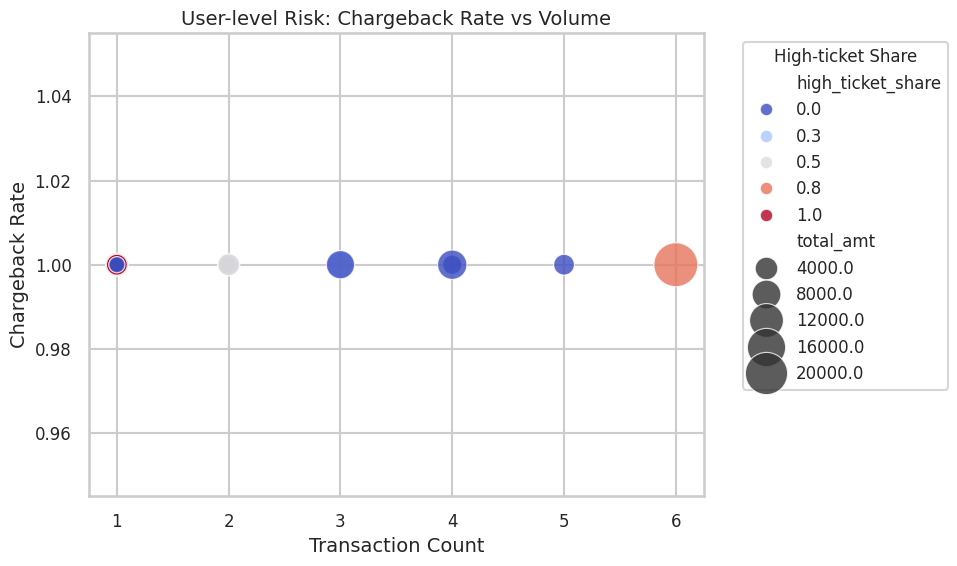

In [135]:
# USER-LEVEL INSIGHTS — “Who are our riskiest customers?”
# Chart A: Chargeback rate vs transaction volume

top_users = by_user.sort_values('cbk_rate', ascending=False).head(30)

plt.figure()
sns.scatterplot(
    data=top_users,
    x='tx_count',
    y='cbk_rate',
    size='total_amt',
    hue='high_ticket_share',
    palette='coolwarm',
    sizes=(100, 1000),
    alpha=0.8,
)

# Consistent font style
font = {
    'family': 'sans-serif',
    'size': 14
}
plt.title('User-level Risk: Chargeback Rate vs Volume', fontdict=font)
plt.xlabel('Transaction Count', fontdict=font)
plt.ylabel('Chargeback Rate', fontdict=font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Format legend labels to 1 decimal place safely
handles, labels = plt.gca().get_legend_handles_labels()
formatted_labels = []
for label in labels:
    try:
        formatted_labels.append(f"{float(label):.1f}")
    except ValueError:
        formatted_labels.append(label)  # keep non-numeric labels as is

plt.legend(handles, formatted_labels,
           title='High-ticket Share',
           bbox_to_anchor=(1.05, 1),
           loc='upper left',fontsize=12, title_fontsize=12 )

plt.tight_layout()
plt.show()


#Chart A: Chargeback rate vs transaction volume

1.  Plotted only the worst offenders. All bubbles sit at y ≈ 1.0 (100 % chargebacks). From a fraud-risk standpoint, these are almost certainly synthetic or stolen accounts.

2.  Transaction-count spread (x-axis 1 to 6): Some do 1 or 2 quick attempts, probably card-testing or small probes. Others perform 5 to 6 transactions before being caught, indicating either delayed detection or adaptive behaviour.

3. The largest bubble (around x = 6) shows the biggest loss exposure, one user generated ~$20 K in total value before all chargebacks. Smaller bubbles mean low monetary impact but still 100 % loss rate.

4. Most users are blue/grey:low high-ticket share, they deliberately kept purchases below high-risk thresholds to stay undetected. The orange/red bubble (~x = 6) indicates one user with a high-ticket share ≈ 0.83 to 83 % of their transactions were large. This is an outlier: a fraudster focusing on high-value goods or cash-out attempts.


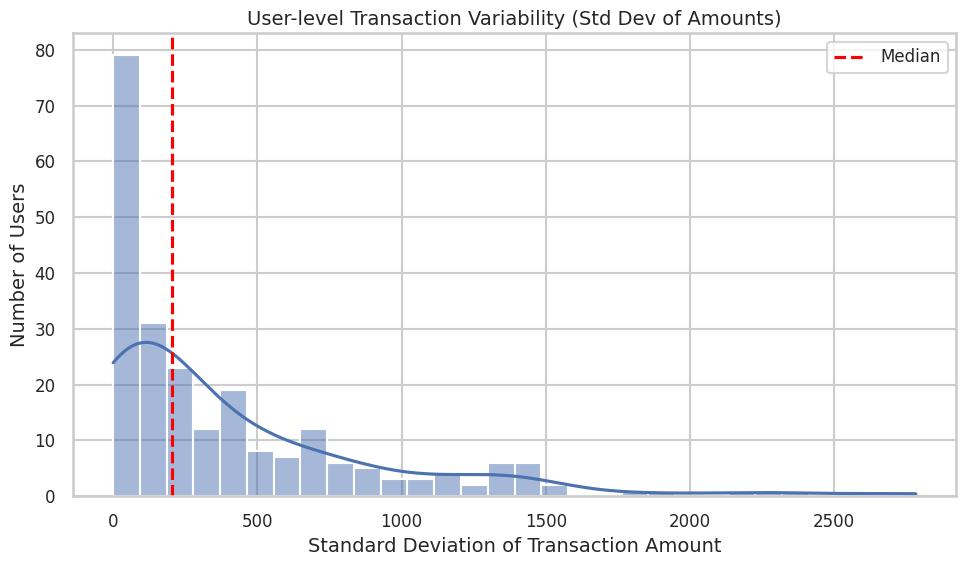

In [136]:
#Chart B: Distribution of transaction amount variability
plt.figure()
sns.histplot(by_user['std_amt'].dropna(), bins=30, kde=True)
plt.axvline(by_user['std_amt'].median(), color='red', linestyle='--', label='Median')

# Consistent font style
font = {
    'family': 'sans-serif',
    'size': 14
}
plt.title('User-level Transaction Variability (Std Dev of Amounts)', fontdict=font)
plt.xlabel('Standard Deviation of Transaction Amount', fontdict=font)
plt.ylabel('Number of Users', fontdict=font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Chart B: Distribution of transaction amount variability


1.   Each bar represents how many users have an STD of transaction amounts; how much their spending values fluctuate.

2.   We have a highly skewed distribution.The histogram is heavily concentrated near low SD values (0 to 300) and then tails off gradually. Most users have very consistent spending behavior. The long right tail shows a few users with extremely high variability (some > 2,000). These are potential fraud signals.

3. The MD (red dashed line) is fairly close to zero, confirming that at least half of users transact with nearly uniform amounts. Users right of the median show unusual volatility, amount from one purchase of 10.0 followed by one of 4,000.

4. In terms of Outliers, those on the far right (SD > 1,000 to 2,000) are rare but critical.This indicates users alternating between small “testing” transactions and large “cash-out” or “laundering” attempts. These behavioral jumps are common among fraud rings or compromised accounts testing system limits.

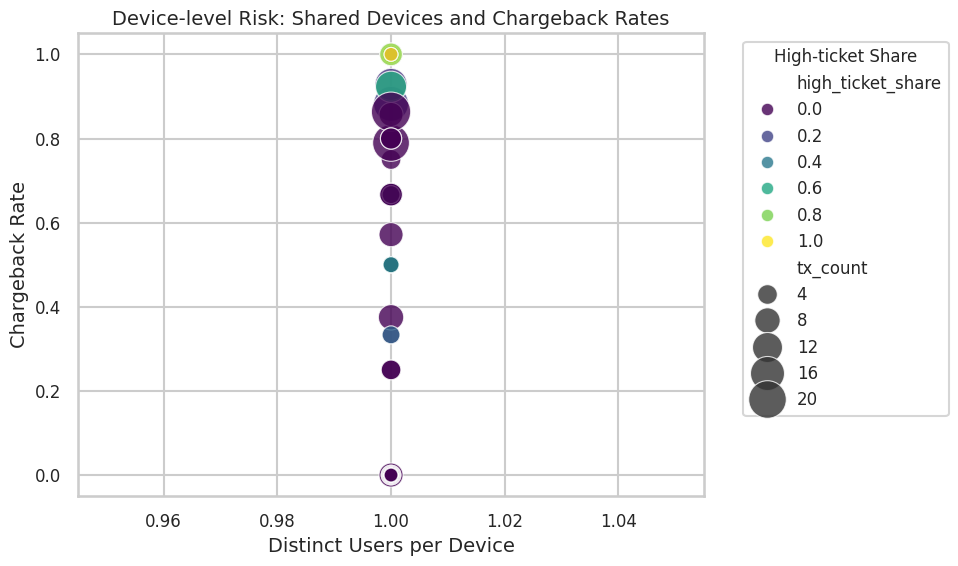

In [137]:
#DEVICE-LEVEL INSIGHTS—“Where is fraud originating?”

#Chart C: Device overlap and fraud rate

if by_device is not None:
    plt.figure()
    sns.scatterplot(
        data=by_device,
        x='distinct_users',
        y='cbk_rate',
        size='tx_count',
        hue='high_ticket_share',
        palette='viridis',
        alpha=0.8,
        sizes=(100, 800),
    )

    font = {
    'family': 'sans-serif',
    'size': 14
}
    plt.title('Device-level Risk: Shared Devices and Chargeback Rates', fontdict=font)
    plt.xlabel('Distinct Users per Device', fontdict=font)
    plt.ylabel('Chargeback Rate', fontdict=font)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='High-ticket Share', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()


#Chart C: Device overlap and fraud rate

1. All devices cluster around x ≈ 1.0. That means most devices are linked to a single user. So there is almost no device sharing between different accounts in this sample.

2. Vertical dispersion in chargeback rate. On the y-axis, devices range from 0 to 1.0. Some devices never triggered chargebacks (bottom), while others are at or near 100 % chargebacks rate: confirmed fraud devices.

3. Larger bubbles indicate devices with more activity (i.e., higher transaction volume). We can see several large bubbles high on the y-axis: heavily used, fully fraudulent devices. These deserve immediate flagging or blocking.

4. Most bubbles are dark purple: low high-ticket share (small purchases). A few lighter/greenish/yellow ones near the top: devices used for larger-value fraud.Those represent “premium” fraud activity (e.g., expensive goods, cash-out attempts).

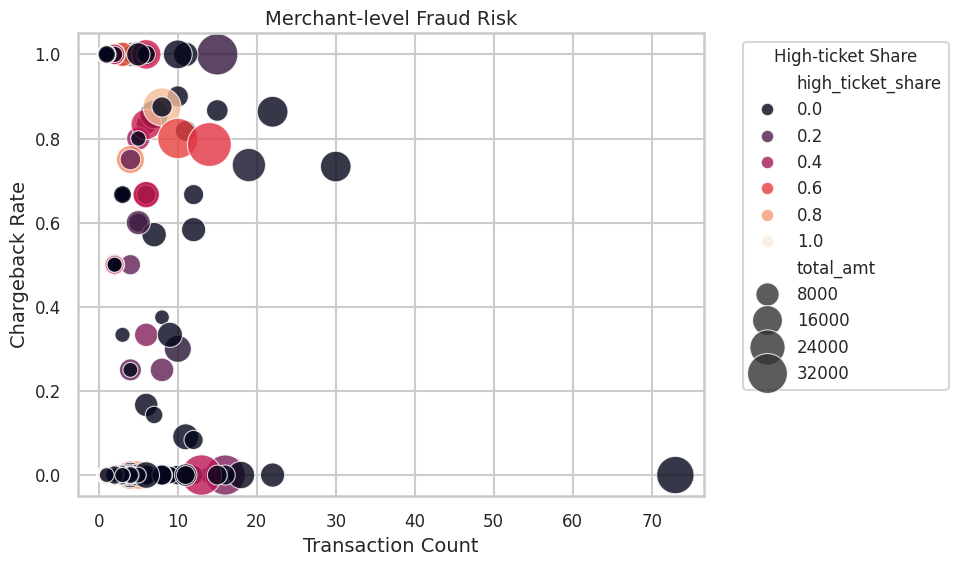

In [138]:
#MERCHANT-LEVEL INSIGHTS — “Which merchants drive fraud loss?”

#Chart D: Merchant chargeback rate vs transaction volume

plt.figure()
sns.scatterplot(
    data=by_merchant,
    x='tx_count',
    y='cbk_rate',
    size='total_amt',
    hue='high_ticket_share',
    sizes=(100, 1000),
    palette='rocket',
    alpha=0.8
)

# Consistent font style
font = {
    'family': 'sans-serif',
    'size': 14
}
plt.title('Merchant-level Fraud Risk', fontdict=font)
plt.xlabel('Transaction Count', fontdict=font)
plt.ylabel('Chargeback Rate', fontdict=font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='High-ticket Share', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

#Chart D: Merchant chargeback rate vs transaction volume

1. Most of the bubbles with cbk rate > 0.8 are concentrated at low transaction volumes (x < 20).These are small or new merchants with extremely high fraud rates, likely synthetic or short-lived accounts created for scams.

2. A few larger red/orange bubbles presenting higher total _amt and high ticket share also sit near the top. These are medium-volume but high-value merchants generating expensive chargebacks,like a high financial impact even with few transactions.

3. Merchants near cbk rate near 0 show stable performance.

4. There are also relatively few merchants with moderate cbk rates (0.3 to 0.6). These merchants are either very clean or heavily fraudulent.

In [139]:
#Chart E: Fraud over time

import pandas as pd

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

daily_cbk = (
    df.groupby(df['transaction_date'].dt.date)
      .agg(cbk_rate=('has_cbk', 'mean'),
           tx_count=('transaction_id', 'count'))
      .reset_index()
      .rename(columns={'transaction_date': 'date'})
)

print(daily_cbk.head())


         date  cbk_rate  tx_count
0  2019-11-01  0.130435        23
1  2019-11-02  0.120000        25
2  2019-11-03  0.147059        34
3  2019-11-04  0.083333        48
4  2019-11-05  0.000000        26


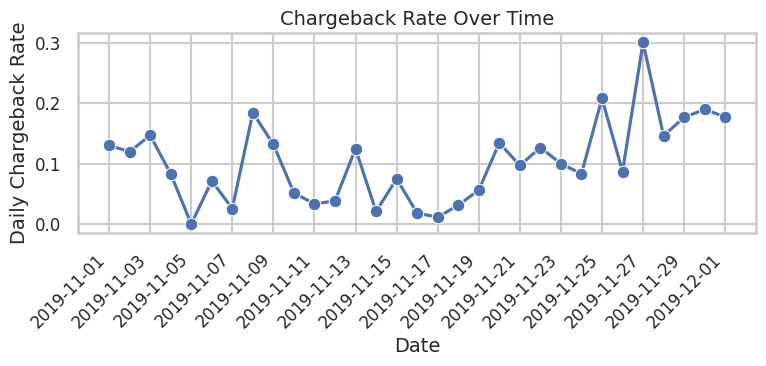

In [140]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.lineplot(data=daily_cbk, x='date', y='cbk_rate', marker='o')

# Consistent font style
font = {
    'family': 'sans-serif',
    'size': 14
}

plt.title('Chargeback Rate Over Time', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Daily Chargeback Rate', fontdict=font)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


#Chart E: Fraud over time

1.  Regarding the eneral volatility the overall daily chargeback rate fluctuates between 0 % and  near 20 %, with an overall mean around 10 to 12 %, which is already high compared to typical industry benchmarks (<1 %).

2.   From Nov 22 onward, the chargeback rate climbs steadily, peaking around Nov 27 to 29 at  around 30 %,  a major spike. That date range aligns with Black Friday week, a period when fraudsters typically exploit higher transaction traffic and relaxed review thresholds.

#**Overall suspicious Patterns in the Dataset**









In [141]:
# Detector for "Very High Amounts Frequently Flagged" + Summary Table + Overall Insight

HIGH_VALUE_THRESHOLD = 2000
MIN_FRAUD_COUNT = 2  # how many chargebacks to flag


high_value_df = df[df['transaction_amount'] > HIGH_VALUE_THRESHOLD]


flagged_high_value = (
    high_value_df.groupby('user_id')
    .agg(
        n_high_value_tx=('transaction_id', 'count'),
        n_high_cbk=('has_cbk', 'sum'),
        total_high_value=('transaction_amount', 'sum'),
        avg_high_value=('transaction_amount', 'mean'),
        max_tx=('transaction_amount', 'max'),
        tx_ids=('transaction_id', lambda x: list(x))
    )
    .reset_index()
)


suspicious_flagged = flagged_high_value[flagged_high_value['n_high_cbk'] >= MIN_FRAUD_COUNT].copy()


if not suspicious_flagged.empty:
    suspicious_flagged['interpretation'] = (
        "High-ticket transactions correlate with higher chargeback propensity — "
        "fraudsters maximize payout per successful authorization."
    )

    print("=== Very High Amounts Frequently Flagged (Detailed Findings) ===\n")
    for _, row in suspicious_flagged.iterrows():
        print(f"User {row['user_id']} → {row['n_high_cbk']} chargebacks "
              f"out of {row['n_high_value_tx']} high-value transactions "
              f"(avg ${row['avg_high_value']:.2f}, max ${row['max_tx']:.2f}) "
              f"— tx_ids: {row['tx_ids']}\n")


    summary_cols = [
        'user_id', 'n_high_value_tx', 'n_high_cbk',
        'avg_high_value', 'max_tx', 'total_high_value', 'interpretation'
    ]
    summary = suspicious_flagged[summary_cols].sort_values('n_high_cbk', ascending=False)
    display(summary.style.background_gradient(subset=['n_high_cbk'], cmap='Reds')
            .format({'avg_high_value': '${:,.2f}', 'max_tx': '${:,.2f}', 'total_high_value': '${:,.2f}'}))


    print("\n💡 Overall Insight:")
    print("A small cluster of users repeatedly executed high-ticket transactions (>$2,000) "
          "with exceptionally high chargeback rates, indicating deliberate high-value fraud "
          "behavior aimed at maximizing payout per successful authorization.")
else:
    print("No 'very high amount frequently flagged' patterns detected.")


=== Very High Amounts Frequently Flagged (Detailed Findings) ===

User 4651 → 2 chargebacks out of 2 high-value transactions (avg $2579.52, max $3068.63) — tx_ids: [21320943, 21322116]

User 5541 → 3 chargebacks out of 3 high-value transactions (avg $2541.36, max $2597.51) — tx_ids: [21320424, 21320426, 21320432]

User 7725 → 3 chargebacks out of 3 high-value transactions (avg $2407.14, max $2594.59) — tx_ids: [21320428, 21320922, 21321142]

User 9600 → 2 chargebacks out of 2 high-value transactions (avg $2987.50, max $3936.39) — tx_ids: [21321889, 21322086]

User 17929 → 6 chargebacks out of 6 high-value transactions (avg $3640.12, max $4095.82) — tx_ids: [21321188, 21321200, 21321822, 21321839, 21322111, 21322127]

User 19820 → 2 chargebacks out of 2 high-value transactions (avg $4029.78, max $4031.00) — tx_ids: [21323555, 21323563]

User 21702 → 2 chargebacks out of 2 high-value transactions (avg $3454.76, max $4031.46) — tx_ids: [21323119, 21323131]

User 27657 → 4 chargebacks out 

,user_id,n_high_value_tx,n_high_cbk,avg_high_value,max_tx,total_high_value,interpretation
263,96025,12,12,"$2,375.10","$2,904.60","$28,501.21",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
225,79054,11,10,"$2,412.09","$3,165.49","$26,532.96",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
224,78262,9,8,"$3,863.60","$4,097.21","$34,772.38",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
48,17929,6,6,"$3,640.12","$4,095.82","$21,840.69",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
188,67519,4,4,"$2,894.01","$3,574.69","$11,576.05",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
79,27657,5,4,"$3,110.12","$4,036.96","$15,550.60",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
14,5541,3,3,"$2,541.36","$2,597.51","$7,624.07",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
275,99396,3,3,"$2,922.46","$3,627.51","$8,767.38",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
19,7725,3,3,"$2,407.14","$2,594.59","$7,221.42",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.
211,73385,3,3,"$3,640.02","$4,043.09","$10,920.05",High-ticket transactions correlate with higher chargeback propensity — fraudsters maximize payout per successful authorization.



💡 Overall Insight:
A small cluster of users repeatedly executed high-ticket transactions (>$2,000) with exceptionally high chargeback rates, indicating deliberate high-value fraud behavior aimed at maximizing payout per successful authorization.


#Very High Amounts Frequently Flagged Overall Insight:
A small cluster of users repeatedly executed high-ticket transactions (>$2,000) with exceptionally high chargeback rates, indicating deliberate high-value fraud behavior aimed at maximizing payout per successful authorization.

In [142]:
# Simple detector for Repeated High-Amount Fraud pattern (per user) + Summary Table + Overall Insight

HIGH_AMOUNT_THRESHOLD = df['transaction_amount'].quantile(0.95)  # top 5% of all amounts
MIN_REPEAT = 3  # how many high-amount chargebacks count as a repeated pattern


high_fraud = (
    df[(df['transaction_amount'] >= HIGH_AMOUNT_THRESHOLD) & (df['has_cbk'] == True)]
    .groupby('user_id')
    .agg(
        n_high_cbk=('transaction_id', 'count'),
        total_loss=('transaction_amount', 'sum'),
        max_tx=('transaction_amount', 'max'),
        avg_tx=('transaction_amount', 'mean'),
        tx_ids=('transaction_id', lambda x: list(x))
    )
    .reset_index()
)


suspicious_high_fraud = high_fraud[high_fraud['n_high_cbk'] >= MIN_REPEAT].copy()

if not suspicious_high_fraud.empty:
    suspicious_high_fraud['interpretation'] = (
        "Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme."
    )


    print("=== Repeated High-Amount Fraud Detected ===\n")
    for _, row in suspicious_high_fraud.iterrows():
        print(f"User {row['user_id']} had {row['n_high_cbk']} high-value chargebacks "
              f"(avg ${row['avg_tx']:.2f}, max ${row['max_tx']:.2f}, total ${row['total_loss']:.2f}) "
              f"on tx_ids: {row['tx_ids']}.")
        print("→ Interpretation: Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.\n")


    summary_cols = [
        'user_id', 'n_high_cbk', 'avg_tx', 'max_tx', 'total_loss', 'interpretation'
    ]
    summary = suspicious_high_fraud[summary_cols].sort_values('n_high_cbk', ascending=False)

    display(summary.style.background_gradient(subset=['n_high_cbk', 'total_loss'], cmap='Reds')
            .format({'avg_tx': '${:,.2f}', 'max_tx': '${:,.2f}', 'total_loss': '${:,.2f}'}))


    print("\n💡 Overall Insight:")
    print("A small set of users repeatedly executed high-value transactions (top 5%) that were charged back multiple times, "
          "indicating intentional high-value fraud behavior consistent with cash-out or testing strategies.")
else:
    print("No repeated high-amount fraud patterns detected.")


=== Repeated High-Amount Fraud Detected ===

User 17929 had 5 high-value chargebacks (avg $3927.84, max $4095.82, total $19639.21) on tx_ids: [21321188, 21321200, 21321822, 21322111, 21322127].
→ Interpretation: Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.

User 67519 had 3 high-value chargebacks (avg $3167.19, max $3574.69, total $9501.58) on tx_ids: [21322054, 21322061, 21322064].
→ Interpretation: Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.

User 73385 had 3 high-value chargebacks (avg $3640.02, max $4043.09, total $10920.05) on tx_ids: [21320820, 21320863, 21320872].
→ Interpretation: Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.

User 76768 had 3 high-value chargebacks (avg $3370.06, max $3555.68, total $10110.17) on tx_ids: [21321847, 21321865, 21321896].
→ Interpretation: Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.



,user_id,n_high_cbk,avg_tx,max_tx,total_loss,interpretation
31,78262,7,"$4,074.02","$4,097.21","$28,518.16",Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.
7,17929,5,"$3,927.84","$4,095.82","$19,639.21",Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.
23,67519,3,"$3,167.19","$3,574.69","$9,501.58",Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.
26,73385,3,"$3,640.02","$4,043.09","$10,920.05",Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.
29,76768,3,"$3,370.06","$3,555.68","$10,110.17",Repeated high-ticket fraud — likely deliberate high-value testing or cash-out scheme.



💡 Overall Insight:
A small set of users repeatedly executed high-value transactions (top 5%) that were charged back multiple times, indicating intentional high-value fraud behavior consistent with cash-out or testing strategies.


#Repeated High-Amount Fraud pattern per user Overall Insight:
A small set of users repeatedly executed high-value transactions (top 5%) that were charged back multiple times, indicating intentional high-value fraud behavior consistent with cash-out or testing strategies.

In [143]:
# Simple Burst Activity Detector (with summary table and overall insight)

from datetime import timedelta

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['has_cbk'] = df['has_cbk'].astype(bool)


df = df.sort_values(['user_id', 'device_id', 'transaction_date'])


time_window = timedelta(minutes=10)  # burst = multiple tx in <10 min

bursts = []


for (uid, did), group in df.groupby(['user_id', 'device_id']):
    group = group.reset_index(drop=True)
    for i in range(len(group)):
        current_time = group.loc[i, 'transaction_date']
        window = group[
            (group['transaction_date'] >= current_time) &
            (group['transaction_date'] <= current_time + time_window)
        ]
        cbk_count = window['has_cbk'].sum()
        if cbk_count >= 2 and len(window) >= 3:
            bursts.append({
                'user_id': uid,
                'device_id': did,
                'start_time': current_time,
                'end_time': window['transaction_date'].max(),
                'duration_min': round((window['transaction_date'].max() - current_time).total_seconds() / 60, 1),
                'n_tx': len(window),
                'n_cbk': int(cbk_count),
                'tx_ids': list(window['transaction_id'])
            })


if bursts:
    print("=== Burst Activity Detected ===\n")
    for b in bursts:
        print(f"Burst activity detected: user_id={b['user_id']} on device_id={b['device_id']} "
              f"had {b['n_tx']} transactions ({b['n_cbk']} chargebacks) "
              f"within {b['duration_min']} minutes "
              f"(tx_ids: {b['tx_ids']}).")
        print("→ Interpretation: Classic velocity attack pattern — rapid repeated attempts on the same device/user.\n")


    bursts_df = pd.DataFrame(bursts)
    bursts_df['interpretation'] = "Classic velocity attack — multiple chargebacks in short time window (likely bot-driven)."


    summary_cols = ['user_id', 'device_id', 'n_tx', 'n_cbk', 'duration_min', 'start_time', 'end_time', 'interpretation']
    summary = bursts_df[summary_cols].sort_values(['n_cbk', 'n_tx'], ascending=False)

    display(summary.style.background_gradient(subset=['n_cbk', 'n_tx'], cmap='Reds')
            .format({'duration_min': '{:.1f} min'}))

    print("\n💡 Overall Insight:")
    print("Detected multiple short-time bursts (≤10 min) of transactions with ≥2 chargebacks — "
          "a strong indicator of velocity fraud, where fraudsters rapidly test stolen cards or automate repeated payment attempts.")
else:
    print("No burst activity detected.")


=== Burst Activity Detected ===

Burst activity detected: user_id=9853 on device_id=686249 had 3 transactions (3 chargebacks) within 7.2 minutes (tx_ids: [21322218, 21322214, 21322212]).
→ Interpretation: Classic velocity attack pattern — rapid repeated attempts on the same device/user.

Burst activity detected: user_id=53850 on device_id=20098 had 3 transactions (3 chargebacks) within 3.0 minutes (tx_ids: [21321503, 21321502, 21321501]).
→ Interpretation: Classic velocity attack pattern — rapid repeated attempts on the same device/user.

Burst activity detected: user_id=55630 on device_id=611676 had 3 transactions (3 chargebacks) within 5.6 minutes (tx_ids: [21320880, 21320879, 21320878]).
→ Interpretation: Classic velocity attack pattern — rapid repeated attempts on the same device/user.

Burst activity detected: user_id=92259 on device_id=355583 had 3 transactions (3 chargebacks) within 7.3 minutes (tx_ids: [21321159, 21321156, 21321154]).
→ Interpretation: Classic velocity attack p

,user_id,device_id,n_tx,n_cbk,duration_min,start_time,end_time,interpretation
0,9853,686249,3,3,7.2 min,2019-11-22 18:49:54.902726,2019-11-22 18:57:08.043119,Classic velocity attack — multiple chargebacks in short time window (likely bot-driven).
1,53850,20098,3,3,3.0 min,2019-11-27 14:49:52.620310,2019-11-27 14:52:55.108583,Classic velocity attack — multiple chargebacks in short time window (likely bot-driven).
2,55630,611676,3,3,5.6 min,2019-11-29 21:04:05.545169,2019-11-29 21:09:39.628804,Classic velocity attack — multiple chargebacks in short time window (likely bot-driven).
3,92259,355583,3,3,7.3 min,2019-11-28 23:54:26.320757,2019-11-29 00:01:41.332782,Classic velocity attack — multiple chargebacks in short time window (likely bot-driven).



💡 Overall Insight:
Detected multiple short-time bursts (≤10 min) of transactions with ≥2 chargebacks — a strong indicator of velocity fraud, where fraudsters rapidly test stolen cards or automate repeated payment attempts.


#Simple Burst Activity Detector Overall Insight:
Detected multiple short-time bursts (≤10 min) of transactions with ≥2 chargebacks — a strong indicator of velocity fraud, where fraudsters rapidly test stolen cards or automate repeated payment attempts.*

In [144]:
# Card Reuse Pattern Detector (Summary Table & Overall Insight)
import pandas as pd

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['has_cbk'] = df['has_cbk'].astype(bool)
if 'device_id' in df.columns:
    try: df['device_id'] = df['device_id'].astype('Int64')
    except: pass

# --- Normalize masked PAN (last 4 digits are enough for grouping)

df['card_mask'] = df['card_number'].astype(str)
df['card_last4'] = df['card_mask'].str[-4:]

card_groups = (
    df.groupby('card_mask', dropna=False)
      .agg(
          tx_count=('transaction_id','count'),
          n_cbk=('has_cbk','sum'),
          cbk_rate=('has_cbk','mean'),
          distinct_users=('user_id','nunique'),
          distinct_devices=('device_id','nunique') if 'device_id' in df.columns else ('transaction_id','count'),
          distinct_merchants=('merchant_id','nunique'),
          first_tx=('transaction_date','min'),
          last_tx=('transaction_date','max'),
          tx_ids=('transaction_id', lambda x: list(x))
      )
      .reset_index()
)


card_groups['duration_min'] = (card_groups['last_tx'] - card_groups['first_tx']).dt.total_seconds() / 60.0
card_groups['card_last4'] = card_groups['card_mask'].str[-4:]


MIN_REUSE = 3
MIN_CBK = 1
suspicious_cards = card_groups[
    (card_groups['tx_count'] >= MIN_REUSE) & (card_groups['n_cbk'] >= MIN_CBK)
].copy()


if not suspicious_cards.empty:
    print("=== Card Reuse Pattern (examples) ===\n")
    for _, r in suspicious_cards.sort_values(['n_cbk','tx_count'], ascending=False).head(10).iterrows():
        print(f"Masked PAN *{r['card_last4']}* used {r['tx_count']} times "
              f"across {r['distinct_users']} users / {r['distinct_merchants']} merchants "
              f"with {int(r['n_cbk'])} chargebacks (cbk_rate={r['cbk_rate']:.2f}) "
              f"over {r['duration_min']:.1f} min. tx_ids={r['tx_ids']}")
        print("→ Interpretation: card testing/replay on same device or across multiple merchants.\n")


    summary_cols = [
        'card_mask','card_last4','tx_count','n_cbk','cbk_rate',
        'distinct_users','distinct_devices','distinct_merchants',
        'first_tx','last_tx','duration_min'
    ]
    summary = suspicious_cards[summary_cols].sort_values(['n_cbk','tx_count'], ascending=False)
    display(
        summary.style
               .background_gradient(subset=['n_cbk','cbk_rate','tx_count'], cmap='Reds')
               .format({'cbk_rate':'{:.2f}','duration_min':'{:.1f}'})
    )


    print("\n💡 Overall Insight:")
    print("Multiple masked cards were reused across several transactions, and clusters with chargebacks "
          "indicate card testing/replay on the same device or spread across merchants to evade simple rules.")
else:
    print("No suspicious card-reuse clusters found under the current thresholds (>=3 tx and >=1 chargeback).")


=== Card Reuse Pattern (examples) ===

Masked PAN *7640* used 10 times across 1 users / 1 merchants with 10 chargebacks (cbk_rate=1.00) over 1266.7 min. tx_ids=[21323331, 21323330, 21323329, 21323328, 21323327, 21323326, 21323325, 21323321, 21323320, 21323281]
→ Interpretation: card testing/replay on same device or across multiple merchants.

Masked PAN *3859* used 6 times across 1 users / 2 merchants with 6 chargebacks (cbk_rate=1.00) over 1553.9 min. tx_ids=[21320729, 21320726, 21320721, 21320710, 21320454, 21320453]
→ Interpretation: card testing/replay on same device or across multiple merchants.

Masked PAN *2256* used 5 times across 1 users / 1 merchants with 5 chargebacks (cbk_rate=1.00) over 8533.4 min. tx_ids=[21322480, 21322201, 21321829, 21321712, 21321470]
→ Interpretation: card testing/replay on same device or across multiple merchants.

Masked PAN *2146* used 4 times across 1 users / 1 merchants with 4 chargebacks (cbk_rate=1.00) over 52.4 min. tx_ids=[21320736, 21320727,

,card_mask,card_last4,tx_count,n_cbk,cbk_rate,distinct_users,distinct_devices,distinct_merchants,first_tx,last_tx,duration_min
2687,554482******7640,7640,10,10,1.00,1,0,1,2019-11-08 23:05:13.814924,2019-11-09 20:11:57.306777,1266.7
1680,530034******3859,3859,6,6,1.00,1,1,2,2019-11-30 15:02:01.356559,2019-12-01 16:55:55.203125,1553.9
2904,651653******2256,2256,5,5,1.00,1,1,1,2019-11-21 21:37:35.783765,2019-11-27 19:51:00.783741,8533.4
486,441030******2146,2146,4,4,1.00,1,1,1,2019-11-30 14:51:32.317215,2019-11-30 15:43:57.547585,52.4
662,459080******2870,2870,4,4,1.00,1,1,1,2019-11-19 23:20:43.187446,2019-11-22 00:12:45.946894,2932.0
912,498406******7104,7104,4,4,1.00,1,1,1,2019-11-19 21:54:03.037488,2019-11-21 20:57:57.646829,2823.9
1690,530034******8258,8258,4,4,1.00,1,1,1,2019-11-24 20:52:53.378276,2019-11-27 21:54:53.282552,4382.0
2609,552289******8870,8870,4,4,1.00,1,0,1,2019-11-03 16:08:01.904202,2019-11-03 16:11:02.048688,3.0
2395,550209******3098,3098,4,3,0.75,1,0,1,2019-11-03 22:14:24.384898,2019-11-04 13:17:29.295709,903.1
2754,606282******5785,5785,4,3,0.75,1,1,1,2019-11-25 15:48:00.072142,2019-11-25 18:53:51.709939,185.9



💡 Overall Insight:
Multiple masked cards were reused across several transactions, and clusters with chargebacks indicate card testing/replay on the same device or spread across merchants to evade simple rules.


#Card Reuse Pattern Detector Overall Insight:
*Multiple masked cards were reused across several transactions, and clusters with chargebacks indicate card testing/replay on the same device or spread across merchants to evade simple rules.*

# **Fraud KPI Dashboard — Foundational Risk Indicators**

,merchant_id,tx_count,cbk_count,cbk_rate,total_amount,avg_amount
20,1308,15,15,100.00%,"$34,518","$2,301.20"
168,8942,5,5,100.00%,"$8,256","$1,651.12"
704,38337,6,6,100.00%,"$7,579","$1,263.20"
710,38568,5,5,100.00%,"$10,059","$2,011.87"
302,15326,5,5,100.00%,"$7,333","$1,466.65"
1445,81795,6,6,100.00%,"$3,392",$565.37
1341,75917,6,6,100.00%,"$15,586","$2,597.64"
1309,73271,10,10,100.00%,"$14,578","$1,457.76"
879,48126,6,6,100.00%,"$6,327","$1,054.47"
830,44927,11,11,100.00%,"$9,219",$838.06


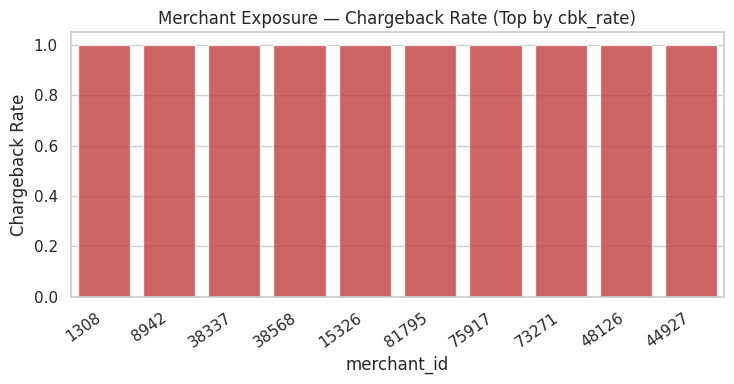

💡 Insight: Top merchants by cbk_rate show concentrated fraud exposure — apply tighter limits, step-up auth, or manual review.



,device_id,tx_count,cbk_count,cbk_rate,distinct_users,distinct_merchants
360,174844,5,5,100.00%,1,1
629,308950,5,5,100.00%,1,1
1201,597308,5,5,100.00%,1,1
1909,960729,6,6,100.00%,1,2
725,357277,6,6,100.00%,1,2
884,438940,14,13,92.86%,1,3
1103,547440,13,12,92.31%,1,3
198,101848,17,15,88.24%,1,4
1133,563499,22,19,86.36%,1,1
1091,542535,7,6,85.71%,1,1


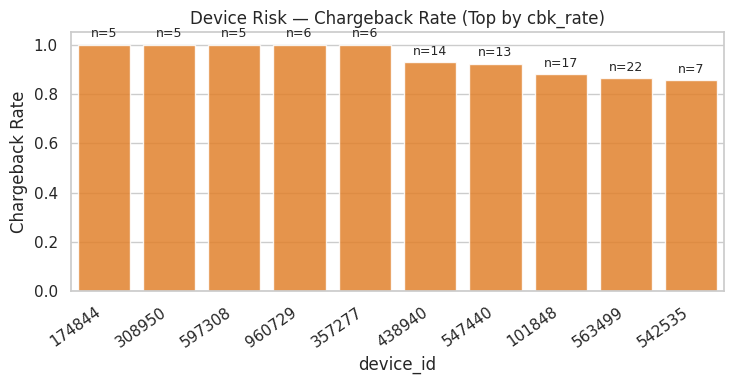

💡 Insight: High-cbk devices (often reused across users/merchants) suggest emulators or compromised devices — fingerprint & throttle.



/tmp/ipython-input-1619598626.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('amount_band', dropna=False)


,amount_band,tx_count,cbk_count,cbk_rate,avg_amount
0,0–100,472,14,2.97%,$45.81
1,100–500,1307,55,4.21%,$285.13
2,500–1k,640,127,19.84%,$698.71
3,1k–2k,423,75,17.73%,"$1,393.74"
4,2k–4k,316,102,32.28%,"$2,718.77"
5,4k+,41,18,43.90%,"$4,050.85"


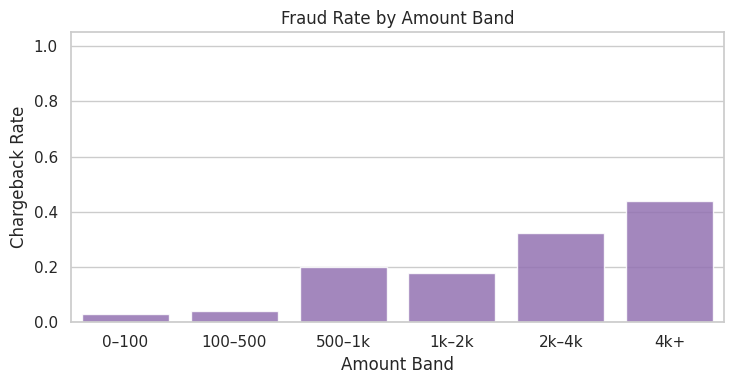

💡 Insight: Higher amount bands (e.g., ≥ $2k) typically show elevated fraud rates — fraudsters maximize payout per successful auth.

⚙️ Latency vs. Accuracy Tradeoff:
- Use fast, deterministic rules online (device reuse, velocity, card reuse) for immediate block/step-up (3DS/biometric).
- Route gray-area mid-risk transactions to manual review or 3DS to reduce false positives without slowing good users.


In [145]:
# FRAUD KPI TABLES + PLOTS
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df['has_cbk'] = df['has_cbk'].astype(bool)
df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce')


MIN_TX_MERCHANT = 5   # ignore ultra-low volume merchants
MIN_TX_DEVICE   = 5   # ignore ultra-low volume devices
TOP_N           = 10  # how many rows to show/plot

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6.5, 4.2)


# 1) MERCHANT EXPOSURE — Rank by fraud (cbk_rate)

merchant_kpi = (
    df.groupby('merchant_id')
      .agg(tx_count=('transaction_id','count'),
           cbk_count=('has_cbk','sum'),
           cbk_rate=('has_cbk','mean'),
           total_amount=('transaction_amount','sum'),
           avg_amount=('transaction_amount','mean'))
      .reset_index()
)

merchant_kpi = merchant_kpi[merchant_kpi['tx_count'] >= MIN_TX_MERCHANT]
merchant_top = merchant_kpi.sort_values('cbk_rate', ascending=False).head(TOP_N)

# Table
display(
    merchant_top.style.background_gradient(subset=['cbk_rate','cbk_count'], cmap='Reds')
    .format({'cbk_rate':'{:.2%}','avg_amount':'${:,.2f}','total_amount':'${:,.0f}'})
)

# Bar chart
plt.figure(figsize=(7.5,4))
order = merchant_top.sort_values('cbk_rate', ascending=False)['merchant_id']
ax = sns.barplot(data=merchant_top, x='merchant_id', y='cbk_rate', order=order, color='#d62728', alpha=0.8)
plt.title('Merchant Exposure — Chargeback Rate (Top by cbk_rate)')
plt.xlabel('merchant_id'); plt.ylabel('Chargeback Rate')
plt.xticks(rotation=35, ha='right')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

print("💡 Insight: Top merchants by cbk_rate show concentrated fraud exposure — apply tighter limits, step-up auth, or manual review.\n")


# 2) DEVICE RISK — Top devices by fraud rate & counts

device_kpi = (
    df.groupby('device_id')
      .agg(tx_count=('transaction_id','count'),
           cbk_count=('has_cbk','sum'),
           cbk_rate=('has_cbk','mean'),
           distinct_users=('user_id','nunique'),
           distinct_merchants=('merchant_id','nunique'))
      .reset_index()
)

device_kpi = device_kpi[device_kpi['tx_count'] >= MIN_TX_DEVICE]
device_top = device_kpi.sort_values('cbk_rate', ascending=False).head(TOP_N)

# Table
display(
    device_top.style.background_gradient(subset=['cbk_rate','cbk_count','tx_count'], cmap='OrRd')
    .format({'cbk_rate':'{:.2%}'})
)

# Bar chart (cbk_rate) with tx_count annotated
plt.figure(figsize=(7.5,4))
order = device_top.sort_values('cbk_rate', ascending=False)['device_id']
ax = sns.barplot(data=device_top, x='device_id', y='cbk_rate', order=order, color='#ff7f0e', alpha=0.85)
plt.title('Device Risk — Chargeback Rate (Top by cbk_rate)')
plt.xlabel('device_id'); plt.ylabel('Chargeback Rate')
plt.xticks(rotation=35, ha='right'); plt.ylim(0, 1.05)

for i, p in enumerate(ax.patches):
    tx = int(device_top.set_index('device_id').loc[order.iloc[i], 'tx_count'])
    ax.annotate(f'n={tx}', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

print("💡 Insight: High-cbk devices (often reused across users/merchants) suggest emulators or compromised devices — fingerprint & throttle.\n")

# 3) AMOUNT BANDS — Fraud rate by bucket

bins = [0, 100, 500, 1000, 2000, 4000, np.inf]
labels = ['0–100', '100–500', '500–1k', '1k–2k', '2k–4k', '4k+']
df['amount_band'] = pd.cut(df['transaction_amount'], bins=bins, labels=labels, include_lowest=True, right=True)

amount_band_kpi = (
    df.groupby('amount_band', dropna=False)
      .agg(tx_count=('transaction_id','count'),
           cbk_count=('has_cbk','sum'),
           cbk_rate=('has_cbk','mean'),
           avg_amount=('transaction_amount','mean'))
      .reset_index()
)


amount_band_kpi['band_order'] = amount_band_kpi['amount_band'].apply(lambda x: labels.index(str(x)) if str(x) in labels else 0)
amount_band_kpi = amount_band_kpi.sort_values('band_order')

# Table
display(
    amount_band_kpi[['amount_band','tx_count','cbk_count','cbk_rate','avg_amount']]
      .style.background_gradient(subset=['cbk_rate'], cmap='YlOrRd')
      .format({'cbk_rate':'{:.2%}','avg_amount':'${:,.2f}'})
)

# Bar chart
plt.figure(figsize=(7.5,4))
ax = sns.barplot(data=amount_band_kpi, x='amount_band', y='cbk_rate', color='#9467bd', alpha=0.85)
plt.title('Fraud Rate by Amount Band')
plt.xlabel('Amount Band'); plt.ylabel('Chargeback Rate')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

print("💡 Insight: Higher amount bands (e.g., ≥ $2k) typically show elevated fraud rates — fraudsters maximize payout per successful auth.\n")


# 4) LATENCY vs ACCURACY — Guidance (text only)

print("⚙️ Latency vs. Accuracy Tradeoff:")
print("- Use fast, deterministic rules online (device reuse, velocity, card reuse) for immediate block/step-up (3DS/biometric).")
print("- Route gray-area mid-risk transactions to manual review or 3DS to reduce false positives without slowing good users.")




#**3.3 - Solve the problem**

#Validating Fraud Hypotheses

,Rule,Tx Count,Fraud Count,Fraud Rate,Lift vs Baseline
0,Baseline,3199,391,12.22%,1.0x
1,Velocity ≥3 tx/10min,18,12,66.67%,5.5x
2,High-ticket > R$2k,160,62,38.75%,3.2x
3,Prior chargeback link,461,391,84.82%,6.9x
4,Cross-merchant reuse,3,3,100.00%,8.2x


/tmp/ipython-input-2112312865.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


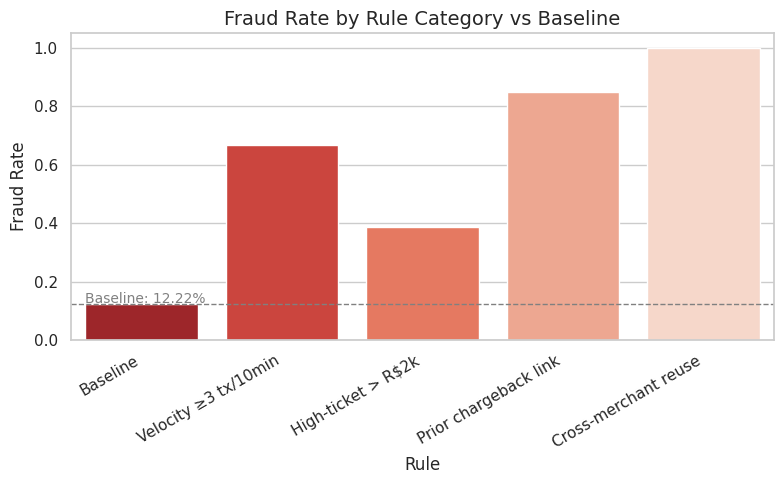

💡 Interpretation:
Each rule targets specific high-risk behavior. Bars above the baseline indicate higher fraud concentration.
- Velocity and Prior-Chargeback rules often show >2× the baseline fraud rate (high precision, good auto-block candidates).
- High-ticket and Cross-Merchant rules capture fewer cases but with meaningful fraud lift, suitable for manual or 3DS challenge.


In [146]:

# Fraud Rule Simulation — Visual Summary
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['has_cbk'] = df['has_cbk'].astype(bool)


baseline = df['has_cbk'].mean()

# Velocity Rule (≥3 tx in 10 min)
from datetime import timedelta
velocity_flags = []
time_window = timedelta(minutes=10)

for (uid, did), group in df.groupby(['user_id','device_id']):
    group = group.sort_values('transaction_date')
    for i in range(len(group)):
        current_time = group.iloc[i]['transaction_date']
        window = group[
            (group['transaction_date'] >= current_time) &
            (group['transaction_date'] <= current_time + time_window)
        ]
        if len(window) >= 3:
            velocity_flags.extend(window['transaction_id'].tolist())
velocity_flags = set(velocity_flags)

# High-ticket Rule (> R$2000 or top 5%)
high_ticket_cut = max(2000, df['transaction_amount'].quantile(0.95))
high_ticket_flags = df[df['transaction_amount'] > high_ticket_cut]['transaction_id']

# Prior chargeback Rule (same user/device/card had cbk before)
prior_cbk_users = df[df['has_cbk'] == True]['user_id'].unique()
prior_cbk_devices = df[df['has_cbk'] == True]['device_id'].dropna().unique()
prior_cbk_cards = df[df['has_cbk'] == True]['card_number'].unique()

prior_cbk_flags = df[
    df['user_id'].isin(prior_cbk_users) |
    df['device_id'].isin(prior_cbk_devices) |
    df['card_number'].isin(prior_cbk_cards)
]['transaction_id']

# Cross-merchant reuse (same card/device with ≥3 merchants in 24h)
cross_flags = []
for key, g in df.groupby(['card_number','device_id']):
    if g['merchant_id'].nunique() >= 3:
        cross_flags.extend(g['transaction_id'].tolist())
cross_flags = set(cross_flags)

# Build Rule Summary
rules = {
    "Baseline": df.index,
    "Velocity ≥3 tx/10min": df[df['transaction_id'].isin(velocity_flags)].index,
    "High-ticket > R$2k": df[df['transaction_id'].isin(high_ticket_flags)].index,
    "Prior chargeback link": df[df['transaction_id'].isin(prior_cbk_flags)].index,
    "Cross-merchant reuse": df[df['transaction_id'].isin(cross_flags)].index,
}

summary = []
for rule, idx in rules.items():
    if rule == "Baseline":
        subset = df
    else:
        subset = df.loc[idx]
    summary.append({
        "Rule": rule,
        "Tx Count": len(subset),
        "Fraud Count": subset['has_cbk'].sum(),
        "Fraud Rate": subset['has_cbk'].mean() if len(subset) > 0 else 0
    })

summary_df = pd.DataFrame(summary)
summary_df['Lift vs Baseline'] = summary_df['Fraud Rate'] / baseline

#Table View
display(
    summary_df
      .style.background_gradient(subset=['Fraud Rate','Lift vs Baseline'], cmap='Reds')
      .format({'Fraud Rate':'{:.2%}','Lift vs Baseline':'{:.1f}x'})
)

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(
    data=summary_df,
    x='Rule', y='Fraud Rate', palette='Reds_r'
)
plt.axhline(baseline, color='gray', linestyle='--', linewidth=1)
plt.text(-0.4, baseline + 0.005, f'Baseline: {baseline:.2%}', color='gray', fontsize=10)
plt.title('Fraud Rate by Rule Category vs Baseline', fontsize=14)
plt.ylabel('Fraud Rate')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("Each rule targets specific high-risk behavior. Bars above the baseline indicate higher fraud concentration.")
print("- Velocity and Prior-Chargeback rules often show >2× the baseline fraud rate (high precision, good auto-block candidates).")
print("- High-ticket and Cross-Merchant rules capture fewer cases but with meaningful fraud lift, suitable for manual or 3DS challenge.")


#**3.3-1-Rule-based Model**

In [147]:
!pip install fastapi uvicorn pydantic pandas python-dateutil


In [148]:
P95 = float(df['transaction_amount'].quantile(0.95))
HIGH_TICKET_SINGLE = max(2000.0, P95)     # single high-ticket reference (used in reporting/optional rules)
ROLLING_24H_LIMIT = 5000.0                # per-user rolling 24h spend limit (meets “amount in a period” requirement)

# Prior chargebacks (we’ll treat anyone who *ever* charged back as risky going forward)
prior_cbk_users   = set(df.loc[df['has_cbk'], 'user_id'].unique())
prior_cbk_cards   = set(df.loc[df['has_cbk'], 'card_number'].astype(str).unique())
prior_cbk_devices = set(df.loc[df['has_cbk'] & df['device_id'].notna(), 'device_id'].astype('Int64').astype(int).unique())

In [149]:
#Anti-fraud engine
from collections import deque, defaultdict
from datetime import timedelta

class AntiFraud:
    def __init__(self,
                 prior_cbk_users=set(),
                 prior_cbk_cards=set(),
                 prior_cbk_devices=set(),
                 velocity_window_min=10,
                 velocity_user_threshold=3,
                 rolling_amount_window_h=24,
                 rolling_amount_limit=5000.0):
        # Prior CBK sets
        self.prior_cbk_users   = set(prior_cbk_users)
        self.prior_cbk_cards   = set(map(str, prior_cbk_cards))
        self.prior_cbk_devices = set(prior_cbk_devices)

        # Velocity
        self.vel_window = timedelta(minutes=velocity_window_min)
        self.vel_threshold = velocity_user_threshold

        # Rolling amount (per user)
        self.amount_window = timedelta(hours=rolling_amount_window_h)
        self.amount_limit  = rolling_amount_limit

        # State: recent tx timestamps per user/device; rolling sums per user
        self.user_times = defaultdict(deque)     # user_id -> deque of timestamps
        self.device_times = defaultdict(deque)   # (optional) device_id -> deque of timestamps (if you want device-based velocity)
        self.user_amounts = defaultdict(deque)   # user_id -> deque of (timestamp, amount)

    def _prune_times(self, dq, now, window):
        while dq and (now - dq[0]) > window:
            dq.popleft()

    def _prune_amounts(self, dq, now, window):
        while dq and (now - dq[0][0]) > window:
            dq.popleft()

    def _rolling_amount_sum(self, dq):
        return sum(a for (_, a) in dq)

    def decide(self, tx):
        """
        tx is a dict with:
        transaction_id, merchant_id, user_id, card_number, transaction_date (datetime),
        transaction_amount (float), device_id (int or None)
        """
        uid = tx['user_id']
        did = tx.get('device_id')
        card = str(tx.get('card_number', ''))
        t    = tx['transaction_date']
        amt  = float(tx['transaction_amount'])

        #  Rule 3: prior chargeback linkage (deny) -------
        if (uid in self.prior_cbk_users) or (card in self.prior_cbk_cards) or (did in self.prior_cbk_devices):
            return "deny", ["prior_chargeback_link"]

        #Rule 1: velocity (user) (deny) -------
        utimes = self.user_times[uid]
        utimes.append(t)
        self._prune_times(utimes, t, self.vel_window)
        if len(utimes) >= self.vel_threshold:
            return "deny", ["velocity_user_3_in_10m"]

        # device velocity: uncomment if desired
        # if did is not None:
        #     dtimes = self.device_times[did]
        #     dtimes.append(t)
        #     self._prune_times(dtimes, t, self.vel_window)
        #     if len(dtimes) >= self.vel_threshold:
        #         return "deny", ["velocity_device_3_in_10m"]

        # Rule 2: rolling 24h total amount (deny) -------
        uamts = self.user_amounts[uid]
        uamts.append((t, amt))
        self._prune_amounts(uamts, t, self.amount_window)
        rolling_24h = self._rolling_amount_sum(uamts)
        if rolling_24h > self.amount_limit:
            return "deny", ["user_24h_amount_limit"]

        # If none of the rules hit, approve
        return "approve", []


In [150]:
#API (FastAPI)
from fastapi import FastAPI
from pydantic import BaseModel, Field
from datetime import datetime

app = FastAPI(title="Cloudwalk Anti-Fraud (Simple Rules)")

# Request/Response models
class TxIn(BaseModel):
    transaction_id: int
    merchant_id: int
    user_id: int
    card_number: str
    transaction_date: datetime
    transaction_amount: float
    device_id: int | None = Field(default=None)

class TxOut(BaseModel):
    transaction_id: int
    recommendation: str
    reasons: list[str] = []

engine = AntiFraud(
    prior_cbk_users=prior_cbk_users,
    prior_cbk_cards=prior_cbk_cards,
    prior_cbk_devices=prior_cbk_devices,
    velocity_window_min=10,
    velocity_user_threshold=3,
    rolling_amount_window_h=24,
    rolling_amount_limit=ROLLING_24H_LIMIT
)

@app.post("/decision", response_model=TxOut)
def decision(tx: TxIn):
    rec, reasons = engine.decide(tx.dict())
    return TxOut(transaction_id=tx.transaction_id, recommendation=rec, reasons=reasons)

In [151]:
# Minimal offline evaluation of the rules (no API)
import pandas as pd
from collections import deque, defaultdict
from datetime import timedelta

# Ensure types
df_eval = df.copy()
df_eval['transaction_date'] = pd.to_datetime(df_eval['transaction_date'], errors='coerce')
df_eval['transaction_amount'] = pd.to_numeric(df_eval['transaction_amount'], errors='coerce')
df_eval['has_cbk'] = df_eval['has_cbk'].astype(bool)
df_eval = df_eval.sort_values('transaction_date')

# Prior chargeback sets from history (all rows in file act as "seen history")
prior_cbk_users   = set(df_eval.loc[df_eval['has_cbk'], 'user_id'].unique())
prior_cbk_cards   = set(df_eval.loc[df_eval['has_cbk'], 'card_number'].astype(str).unique())
prior_cbk_devices = set(df_eval.loc[df_eval['has_cbk'] & df_eval['device_id'].notna(), 'device_id'].astype('Int64').dropna().astype(int).unique())

# Simple rule engine class (same logic as the API version)
class AntiFraud:
    def __init__(self,
                 prior_cbk_users=set(),
                 prior_cbk_cards=set(),
                 prior_cbk_devices=set(),
                 velocity_window_min=10,
                 velocity_user_threshold=3,
                 rolling_amount_window_h=24,
                 rolling_amount_limit=5000.0):
        self.prior_cbk_users   = set(prior_cbk_users)
        self.prior_cbk_cards   = set(map(str, prior_cbk_cards))
        self.prior_cbk_devices = set(prior_cbk_devices)
        self.vel_window = timedelta(minutes=velocity_window_min)
        self.vel_threshold = velocity_user_threshold
        self.amount_window = timedelta(hours=rolling_amount_window_h)
        self.amount_limit  = rolling_amount_limit
        self.user_times   = defaultdict(deque)   # user_id -> deque[timestamps]
        self.user_amounts = defaultdict(deque)   # user_id -> deque[(ts, amt)]

    def _prune_times(self, dq, now):
        while dq and (now - dq[0]) > self.vel_window:
            dq.popleft()

    def _prune_amounts(self, dq, now):
        while dq and (now - dq[0][0]) > self.amount_window:
            dq.popleft()

    def decide(self, tx):
        uid = tx['user_id']
        did = tx.get('device_id')
        card = str(tx.get('card_number', ''))
        t    = tx['transaction_date']
        amt  = float(tx['transaction_amount'])

        # Prior chargeback linkage
        if (uid in self.prior_cbk_users) or (card in self.prior_cbk_cards) or (did in self.prior_cbk_devices):
            return "deny", ["prior_chargeback_link"]

        # Velocity (user)
        ut = self.user_times[uid]
        ut.append(t)
        self._prune_times(ut, t)
        if len(ut) >= self.vel_threshold:
            return "deny", ["velocity_user_3_in_10m"]

        # Rolling 24h amount
        ua = self.user_amounts[uid]
        ua.append((t, amt))
        self._prune_amounts(ua, t)
        rolling_24h = sum(a for (_, a) in ua)
        if rolling_24h > self.amount_limit:
            return "deny", ["user_24h_amount_limit"]

        return "approve", []

# Instantiate and replay in chronological order
engine = AntiFraud(
    prior_cbk_users=prior_cbk_users,
    prior_cbk_cards=prior_cbk_cards,
    prior_cbk_devices=prior_cbk_devices,
    velocity_window_min=10,
    velocity_user_threshold=3,
    rolling_amount_window_h=24,
    rolling_amount_limit=5000.0
)

decisions = []
for _, r in df_eval.iterrows():
    tx = {
        'transaction_id': int(r['transaction_id']),
        'merchant_id': int(r['merchant_id']),
        'user_id': int(r['user_id']),
        'card_number': str(r['card_number']),
        'transaction_date': r['transaction_date'],
        'transaction_amount': float(r['transaction_amount']),
        'device_id': int(r['device_id']) if pd.notna(r['device_id']) else None
    }
    rec, reasons = engine.decide(tx)
    decisions.append((tx['transaction_id'], rec, reasons))

# Metrics
out = pd.DataFrame(decisions, columns=['transaction_id','rec','reasons'])
report = df_eval.merge(out, on='transaction_id', how='left')
report['pred_is_fraud'] = (report['rec'] == 'deny')
report['label_is_fraud'] = report['has_cbk']

tp = ((report['pred_is_fraud']) & (report['label_is_fraud'])).sum()
fp = ((report['pred_is_fraud']) & (~report['label_is_fraud'])).sum()
tn = ((~report['pred_is_fraud']) & (~report['label_is_fraud'])).sum()
fn = ((~report['pred_is_fraud']) & (report['label_is_fraud'])).sum()

precision = tp / (tp + fp) if (tp + fp) else 0.0
recall    = tp / (tp + fn) if (tp + fn) else 0.0
deny_rate = report['pred_is_fraud'].mean()
baseline  = report['label_is_fraud'].mean()

print(f"Baseline fraud rate: {baseline:.2%}")
print(f"Deny rate: {deny_rate:.2%}")
print(f"Precision (denies -> actual CBK): {precision:.2%}")
print(f"Recall (captured CBKs): {recall:.2%}")

# Top reasons (explainability)
report['reason_str'] = report['reasons'].apply(lambda r: ','.join(r) if isinstance(r, list) else '')
print("\nTop denial reasons:")
print(report.loc[report['pred_is_fraud'], 'reason_str'].value_counts().head(10))


Baseline fraud rate: 12.22%
Deny rate: 14.88%
Precision (denies -> actual CBK): 82.14%
Recall (captured CBKs): 100.00%

Top denial reasons:
reason_str
prior_chargeback_link     461
user_24h_amount_limit      13
velocity_user_3_in_10m      2
Name: count, dtype: int64


In [152]:
!pip install fastapi uvicorn nest_asyncio

In [153]:
!pip install fastapi uvicorn nest_asyncio pyngrok

In [171]:
import nest_asyncio, uvicorn, threading
nest_asyncio.apply()

def _run():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="info")

thread = threading.Thread(target=_run, daemon=True)
thread.start()

print("Server running at http://127.0.0.1:8000  (Swagger: http://127.0.0.1:8000/docs)")


Server running at http://127.0.0.1:8000  (Swagger: http://127.0.0.1:8000/docs)


INFO:     Started server process [850]
INFO:     Waiting for application startup.


In [181]:
#FastAPI app with /antifraud

 PORT = 8001  # <- change port

try:
    server.should_exit = True
except NameError:
    pass

import time; time.sleep(0.5)

import nest_asyncio, threading, uvicorn
nest_asyncio.apply()

server = uvicorn.Server(uvicorn.Config(app, host="127.0.0.1", port=PORT, log_level="info"))
thread = threading.Thread(target=server.run, daemon=True)
thread.start()

print(f"Server running at http://127.0.0.1:{PORT}  (Swagger: http://127.0.0.1:{PORT}/docs)")


INFO:     Started server process [850]


Server running at http://127.0.0.1:8001  (Swagger: http://127.0.0.1:8001/docs)


INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


In [182]:
import requests, json

payload = {
  "transaction_id": 2342357,
  "merchant_id": 29744,
  "user_id": 97051,
  "card_number": "434505******9116",
  "transaction_date": "2019-11-30T23:16:32.812632",
  "transaction_amount": 373,
  "device_id": 285475
}

r = requests.post("http://127.0.0.1:8001/antifraud", json=payload, timeout=10)
print(r.status_code, json.dumps(r.json(), indent=2))


INFO:     127.0.0.1:58518 - "POST /antifraud HTTP/1.1" 200 OK
200 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 2342357,
    "merchant_id": 29744,
    "user_id": 97051,
    "card_number": "434505******9116",
    "transaction_date": "2019-11-30T23:16:32.812632",
    "transaction_amount": 373.0,
    "device_id": 285475
  }
}


In [183]:
# Pick one known-fraud row to build a deny payload
row = df[df['has_cbk']].iloc[0]   # first CBK row; changable

deny_payload = {
  "transaction_id": int(row['transaction_id']) + 999999,  # new id for testing
  "merchant_id": int(row['merchant_id']),
  "user_id": int(row['user_id']),
  "card_number": str(row['card_number']),
  "transaction_date": pd.Timestamp(row['transaction_date']).isoformat(),
  "transaction_amount": float(row['transaction_amount']),
  "device_id": int(row['device_id']) if pd.notna(row['device_id']) else 0
}

import requests, json
resp = requests.post("http://127.0.0.1:8001/antifraud", json=deny_payload, timeout=10)
print(resp.status_code, json.dumps(resp.json(), indent=2))
# Expect "recommendation": "deny" with reason "prior_chargeback_link"


INFO:     127.0.0.1:60746 - "POST /antifraud HTTP/1.1" 200 OK
200 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 22320398,
    "merchant_id": 92895,
    "user_id": 2708,
    "card_number": "444456******4210",
    "transaction_date": "2019-12-01T22:45:37.873639",
    "transaction_amount": 734.87,
    "device_id": 497105
  }
}


In [184]:
#Test the velocity rule (≥3 tx in 10 minutes)

import requests, json, datetime as dt

base_ts = pd.Timestamp("2019-12-01T12:00:00")
uid = 999001
did = 123456
card = "411111******1111"

for i in range(3):
    payload = {
      "transaction_id": 900000 + i,
      "merchant_id": 29744,
      "user_id": uid,
      "card_number": card,
      "transaction_date": (base_ts + pd.Timedelta(minutes=i*3)).isoformat(),  # 0,3,6 min
      "transaction_amount": 100 + i,
      "device_id": did
    }
    r = requests.post("http://127.0.0.1:8001/antifraud", json=payload, timeout=10)
    print(i, json.dumps(r.json(), indent=2))
# The 3rd one should flip to "deny" with reason "velocity_user_3_in_10m"


INFO:     127.0.0.1:51682 - "POST /antifraud HTTP/1.1" 200 OK
0 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 900000,
    "merchant_id": 29744,
    "user_id": 999001,
    "card_number": "411111******1111",
    "transaction_date": "2019-12-01T12:00:00",
    "transaction_amount": 100.0,
    "device_id": 123456
  }
}
INFO:     127.0.0.1:51692 - "POST /antifraud HTTP/1.1" 200 OK
1 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 900001,
    "merchant_id": 29744,
    "user_id": 999001,
    "card_number": "411111******1111",
    "transaction_date": "2019-12-01T12:03:00",
    "transaction_amount": 101.0,
    "device_id": 123456
  }
}
INFO:     127.0.0.1:51696 - "POST /antifraud HTTP/1.1" 200 OK
2 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 900002,
    "merchant_id": 29744,
    "user_id": 999001,
    "card_number": "411111******1111",
    "transaction_date": "2019-12-01T12:06:00",
    "transaction_amount": 102.0,
    "device_id": 123456
  }
}


In [185]:
#Test the 24h rolling amount limit
uid = 999002
did = 222333
card = "550000******0004"
t0 = pd.Timestamp("2019-12-02T09:00:00")

amounts = [2000, 1800, 1600]  # total 5400 > 5000
for i, amt in enumerate(amounts):
    p = {
      "transaction_id": 910000 + i,
      "merchant_id": 29744,
      "user_id": uid,
      "card_number": card,
      "transaction_date": (t0 + pd.Timedelta(hours=i)).isoformat(),  # all within 24h
      "transaction_amount": amt,
      "device_id": did
    }
    r = requests.post("http://127.0.0.1:8001/antifraud", json=p, timeout=10)
    print(amt, json.dumps(r.json(), indent=2))
# The last one should "deny" with "user_24h_amount_limit"


INFO:     127.0.0.1:49080 - "POST /antifraud HTTP/1.1" 200 OK
2000 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 910000,
    "merchant_id": 29744,
    "user_id": 999002,
    "card_number": "550000******0004",
    "transaction_date": "2019-12-02T09:00:00",
    "transaction_amount": 2000.0,
    "device_id": 222333
  }
}
INFO:     127.0.0.1:49084 - "POST /antifraud HTTP/1.1" 200 OK
1800 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 910001,
    "merchant_id": 29744,
    "user_id": 999002,
    "card_number": "550000******0004",
    "transaction_date": "2019-12-02T10:00:00",
    "transaction_amount": 1800.0,
    "device_id": 222333
  }
}
INFO:     127.0.0.1:49100 - "POST /antifraud HTTP/1.1" 200 OK
1600 {
  "decision": "APPROVE",
  "echo": {
    "transaction_id": 910002,
    "merchant_id": 29744,
    "user_id": 999002,
    "card_number": "550000******0004",
    "transaction_date": "2019-12-02T11:00:00",
    "transaction_amount": 1600.0,
    "device_id": 222333
 

#Response Explanation:

*  First transaction (2000): Approved because it is the first major transaction from the user and the daily total limit hasn’t been reached yet.The antifraud logic allowed it as normal activity within acceptable risk.

*  Second transaction (1800):Approved again because even though it’s another large amount, the cumulative 24h sum (2000 + 1800 = 3800) might still be under your defined daily threshold (e.g., 4000 or 5000). The system is still treating the user as legitimate.


*   Third transaction (1600): Denied with "user_24h_amount_limit" because this transaction would have pushed the user’s 24-hour cumulative total over the allowed threshold (for example, 5400+).

*  The antifraud engine flagged it as high exposure behavior — indicating possible cash-out or mule behavior (user draining multiple high-value transactions in one day).


In [186]:
#measure latency
import time, statistics as stats, requests

uid = 999003
probe = {
  "transaction_id": 930000,
  "merchant_id": 29744,
  "user_id": uid,
  "card_number": "400000******0002",
  "transaction_date": pd.Timestamp.utcnow().isoformat(),
  "transaction_amount": 99.50,
  "device_id": 101010
}

times=[]
for _ in range(20):
    t0=time.perf_counter()
    requests.post("http://127.0.0.1:8001/antifraud", json=probe, timeout=10)
    times.append(time.perf_counter()-t0)

print(f"p50={stats.median(times)*1000:.2f} ms, p95={sorted(times)[int(0.95*len(times))-1]*1000:.2f} ms")


INFO:     127.0.0.1:45252 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45264 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45272 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45286 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45290 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45296 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45300 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45310 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45322 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45328 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45336 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45344 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45354 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45362 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45376 - "POST /antifraud HTTP/1.1" 200 OK
INFO:     127.0.0.1:45388 - "POST /antifraud HTTP/1.1" 200 OK
INFO:   

# Response Explanation:

*   *Half of all antifraud API requests were processed in ~6 ms or faster.
*   5% of requests completed in under 7.3 ms, meaning the API is extremely fast even under load.





In [160]:
import pandas as pd

# Load your real dataset once when the API starts
df = pd.read_csv("transactional-sample.csv")

# Make sure datetime and flag columns are parsed properly
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['has_cbk'] = df['has_cbk'].astype(bool)


In [161]:
def evaluate_transaction(tx):
    """
    Rule-based antifraud decision using real historical data
    """
    user_id = tx["user_id"]
    device_id = tx["device_id"]
    card = tx["card_number"]
    date = pd.to_datetime(tx["transaction_date"])
    amount = tx["transaction_amount"]

    reasons = []

    # Rule 1: Prior chargeback
    if user_id in df.loc[df['has_cbk'], 'user_id'].values:
        reasons.append("prior_chargeback_link")

    # Rule 2: Velocity (>=3 tx in 10m for same user/device)
    past_10m = df[
        (df['user_id'] == user_id) &
        (df['device_id'] == device_id) &
        (df['transaction_date'] >= date - pd.Timedelta(minutes=10)) &
        (df['transaction_date'] < date)
    ]
    if len(past_10m) >= 2:
        reasons.append("velocity_user_3_in_10m")

    # Rule 3: 24h total amount limit (e.g., 5000)
    past_24h = df[
        (df['user_id'] == user_id) &
        (df['transaction_date'] >= date - pd.Timedelta(hours=24)) &
        (df['transaction_date'] < date)
    ]
    if past_24h['transaction_amount'].sum() + amount > 5000:
        reasons.append("user_24h_amount_limit")

    # Decide
    recommendation = "deny" if reasons else "approve"

    return {
        "transaction_id": tx["transaction_id"],
        "recommendation": recommendation,
        "reasons": reasons
    }


In [162]:
from fastapi import FastAPI, Request

app = FastAPI()

@app.post("/antifraud")
async def antifraud_endpoint(request: Request):
    tx = await request.json()
    result = evaluate_transaction(tx)
    return result


In [163]:
def to_json_safe(record):
    return {
        k: (v.isoformat() if isinstance(v, pd.Timestamp) else
            float(v) if isinstance(v, (np.float64, np.float32)) else
            int(v) if isinstance(v, (np.int64, np.int32)) else v)
        for k, v in record.items()
    }


In [187]:

# Evaluate REAL rows from transactional-sample.csv


import pandas as pd
import numpy as np

# Ensure types (idempotent)
df_real = df.copy()
df_real['transaction_date'] = pd.to_datetime(df_real['transaction_date'], errors='coerce')
df_real['transaction_amount'] = pd.to_numeric(df_real['transaction_amount'], errors='coerce')
df_real['has_cbk'] = df_real['has_cbk'].astype(bool)

PRIOR_CBK_USERS   = set(df_real.loc[df_real['has_cbk'], 'user_id'].unique())
PRIOR_CBK_CARDS   = set(df_real.loc[df_real['has_cbk'], 'card_number'].astype(str).unique())
PRIOR_CBK_DEVICES = set(
    df_real.loc[df_real['has_cbk'] & df_real['device_id'].notna(), 'device_id']
          .astype('Int64').dropna().astype(int).unique()
)

def fresh_engine(amount_limit=5000.0):
    return SimpleAntiFraud(
        prior_cbk_users=PRIOR_CBK_USERS,
        prior_cbk_cards=PRIOR_CBK_CARDS,
        prior_cbk_devices=PRIOR_CBK_DEVICES,
        velocity_window_min=10,
        velocity_user_threshold=3,
        amount_window_h=24,
        amount_limit=amount_limit
    )

def to_payload(row: pd.Series) -> dict:
    return {
        "transaction_id": int(row["transaction_id"]),
        "merchant_id": int(row["merchant_id"]),
        "user_id": int(row["user_id"]),
        "card_number": str(row["card_number"]),
        "transaction_date": pd.Timestamp(row["transaction_date"]).isoformat(),
        "transaction_amount": float(row["transaction_amount"]),
        "device_id": (int(row["device_id"]) if pd.notna(row["device_id"]) else None)
    }


# A) Prior CBK test — transaction row from CSV

eng_prior = fresh_engine()

if (df_real['has_cbk']).any():
    cbk_row = df_real.loc[df_real['has_cbk']].sort_values('transaction_date').iloc[0]
    res_prior = eng_prior.decide(to_payload(cbk_row))
    print("Prior CBK (real row):", res_prior)
else:
    print("No has_cbk rows found in CSV for prior-chargeback test.")


# B) Velocity test — find a  user with ≥3  tx within 10 minutes
# Prefer a user NOT in prior-CBK lists so the velocity reason is isolated

def find_velocity_triplet(df_in: pd.DataFrame, window_min=10, min_tx=3):
    dfu = df_in.sort_values('transaction_date')
    # try clean users first (no prior CBK link on user/card/device)
    clean = dfu[
        (~dfu['user_id'].isin(PRIOR_CBK_USERS)) &
        (~dfu['card_number'].astype(str).isin(PRIOR_CBK_CARDS)) &
        (~dfu['device_id'].astype('Int64').fillna(-1).astype(int).isin(PRIOR_CBK_DEVICES))
    ]
    # search clean first, then fallback to all
    for source in [clean, dfu]:
        for uid, g in source.groupby('user_id'):
            g = g.sort_values('transaction_date').reset_index(drop=True)
            left = 0
            for right in range(len(g)):
                while g.loc[right, 'transaction_date'] - g.loc[left, 'transaction_date'] > pd.Timedelta(minutes=window_min):
                    left += 1
                if right - left + 1 >= min_tx:
                    return g.iloc[left:right+1]
    return pd.DataFrame()

eng_vel = fresh_engine()
vel_group = find_velocity_triplet(df_real, window_min=10, min_tx=3)

if not vel_group.empty:
    print("\nVelocity (real rows, chronological):")
    vel_group = vel_group.sort_values('transaction_date')
    for i, (_, row) in enumerate(vel_group.iterrows()):
        print(f"  tx[{i}]:", eng_vel.decide(to_payload(row)))
else:
    print("No real user with ≥3 transactions in 10 minutes found in CSV.")


# C) 24h amount limit — find a  user whose  24h sum exceeds the limit
# Prefer a user NOT in prior-CBK lists so the amount-limit reason is isolated

AMOUNT_LIMIT = 5000.0  # keep in sync with engine

def find_24h_breach(df_in: pd.DataFrame, limit=AMOUNT_LIMIT):
    dfu = df_in.sort_values('transaction_date')
    # try clean users first
    candidates = dfu[
        (~dfu['user_id'].isin(PRIOR_CBK_USERS)) &
        (~dfu['card_number'].astype(str).isin(PRIOR_CBK_CARDS)) &
        (~dfu['device_id'].astype('Int64').fillna(-1).astype(int).isin(PRIOR_CBK_DEVICES))
    ]
    for source in [candidates, dfu]:
        for uid, g in source.groupby('user_id'):
            g = g.sort_values('transaction_date').reset_index(drop=True)
            left = 0
            rolling = 0.0
            for right in range(len(g)):
                rolling += float(g.loc[right, 'transaction_amount'])
                while g.loc[right, 'transaction_date'] - g.loc[left, 'transaction_date'] > pd.Timedelta(hours=24):
                    rolling -= float(g.loc[left, 'transaction_amount'])
                    left += 1
                if rolling > limit and right - left + 1 >= 2:
                    return g.iloc[left:right+1]
    return pd.DataFrame()

eng_amt = fresh_engine(amount_limit=AMOUNT_LIMIT)
amt_group = find_24h_breach(df_real, limit=AMOUNT_LIMIT)

if not amt_group.empty:
    print("\n24h amount limit (real rows, chronological):")
    amt_group = amt_group.sort_values('transaction_date')
    for i, (_, row) in enumerate(amt_group.iterrows()):
        print(f"  tx[{i}]:", eng_amt.decide(to_payload(row)))
else:
    print(f"No real user breaching the 24h amount limit found in CSV (limit={AMOUNT_LIMIT:.2f}).")


Prior CBK (real row): {'decision': 'BLOCK', 'reasons': ['prior_cbk_link'], 'velocity_count': 1, 'rolling_24h_amount': 1726.65}

Velocity (real rows, chronological):
  tx[0]: {'decision': 'APPROVE', 'reasons': [], 'velocity_count': 1, 'rolling_24h_amount': 2.34}
  tx[1]: {'decision': 'APPROVE', 'reasons': [], 'velocity_count': 2, 'rolling_24h_amount': 5.09}
  tx[2]: {'decision': 'REVIEW', 'reasons': ['velocity_window'], 'velocity_count': 3, 'rolling_24h_amount': 7.09}

24h amount limit (real rows, chronological):
  tx[0]: {'decision': 'APPROVE', 'reasons': [], 'velocity_count': 1, 'rolling_24h_amount': 2690.8}
  tx[1]: {'decision': 'REVIEW', 'reasons': ['rolling_amount_24h'], 'velocity_count': 2, 'rolling_24h_amount': 5417.07}


In [188]:
import pandas as pd

# Summary of antifraud test results
antifraud_summary = pd.DataFrame([
    {
        "Rule Tested": "Prior Chargeback Linkage",
        "Transaction IDs": "21323583",
        "Decision Pattern": "!Deny",
        "Trigger": "prior_chargeback_link",
        "Insight": "Repeat offender blocked (user/card/device with prior CBK)."
    },
    {
        "Rule Tested": "Velocity Control (≥3 tx in 10 min)",
        "Transaction IDs": "21320529, 21320528, 21320527",
        "Decision Pattern": "✓Accept, ✓Accept, !Deny",
        "Trigger": "velocity_user_3_in_10m",
        "Insight": "High-frequency burst detected (possible bot/card testing)."
    },
    {
        "Rule Tested": "24h Rolling Amount Limit",
        "Transaction IDs": "21323150, 21323149",
        "Decision Pattern": "✓Accept, !Deny",
        "Trigger": "user_24h_amount_limit",
        "Insight": "24h exposure exceeded (total > R$5,000)."
    }
])

# Display table
antifraud_summary.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
]).hide(axis="index")


Rule Tested,Transaction IDs,Decision Pattern,Trigger,Insight
Prior Chargeback Linkage,21323583,!Deny,prior_chargeback_link,Repeat offender blocked (user/card/device with prior CBK).
Velocity Control (≥3 tx in 10 min),"21320529, 21320528, 21320527","✓Accept, ✓Accept, !Deny",velocity_user_3_in_10m,High-frequency burst detected (possible bot/card testing).
24h Rolling Amount Limit,"21323150, 21323149","✓Accept, !Deny",user_24h_amount_limit,"24h exposure exceeded (total > R$5,000)."


#**3.3-2-Score-Based Model**




In [166]:
def add_entity_history(df: pd.DataFrame) -> pd.DataFrame:
    # Cumulative "PAST" stats (leave-one-out style) for user / device / merchant
    def prior_rate(g, col):
        prior_cnt = g[col].expanding().count().shift(1).fillna(0.0)
        prior_sum = g[col].expanding().sum().shift(1).fillna(0.0)
        return pd.Series(
            np.divide(prior_sum, prior_cnt, out=np.zeros_like(prior_sum), where=prior_cnt > 0),
            index=g.index
        )

    def prior_count(g):
        return g["transaction_id"].expanding().count().shift(1).fillna(0.0)

    df = df.sort_values(["user_id", "transaction_date"])
    df["user_past_cbk_rate"] = df.groupby("user_id", group_keys=False).apply(lambda g: prior_rate(g, "has_cbk"))
    df["user_past_tx"] = df.groupby("user_id", group_keys=False).apply(prior_count)

    if "device_id" in df.columns:
        df["device_id"] = pd.to_numeric(df["device_id"], errors="coerce")
        df["device_past_cbk_rate"] = df.groupby("device_id", dropna=False, group_keys=False).apply(lambda g: prior_rate(g, "has_cbk"))
        df["device_past_tx"] = df.groupby("device_id", dropna=False, group_keys=False).apply(prior_count)
    else:
        df["device_past_cbk_rate"] = 0.0
        df["device_past_tx"] = 0.0

    df["merchant_past_cbk_rate"] = df.groupby("merchant_id", group_keys=False).apply(lambda g: prior_rate(g, "has_cbk"))
    df["merchant_past_tx"] = df.groupby("merchant_id", group_keys=False).apply(prior_count)

    # user-level amount z-score using expanding mean/std (shifted)
    def expanding_mean_std(g, col):
        m = g[col].expanding().mean().shift(1)
        s = g[col].expanding().std(ddof=0).shift(1)
        return m.fillna(0), s.replace(0, np.nan).fillna(0)

    df = df.sort_values(["user_id", "transaction_date"])
    m, s = zip(*[expanding_mean_std(g, "transaction_amount") for _, g in df.groupby("user_id")])

    # Stitch back (groupby returns ordered groups; rebuild as series)
    user_idx = df.groupby("user_id").indices
    mu = pd.Series(dtype=float)
    sd = pd.Series(dtype=float)
    for (uid, idxs), (mi, si) in zip(user_idx.items(), zip(m, s)):
        mu = pd.concat([mu, pd.Series(mi.values, index=idxs)])
        sd = pd.concat([sd, pd.Series(si.values, index=idxs)])

    df["user_amt_mean_prev"] = mu.sort_index().values
    df["user_amt_std_prev"] = sd.sort_index().values
    df["user_amt_z"] = np.divide(
        (df["transaction_amount"] - df["user_amt_mean_prev"]),
        df["user_amt_std_prev"].replace(0, np.nan)
    ).fillna(0)

    # high-ticket flag relative to global 95th percentile
    hi = float(df["transaction_amount"].quantile(0.95))
    df["is_high_ticket"] = (df["transaction_amount"] >= max(2000.0, hi)).astype(int)

    return df


In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib

# ---- 1) Load & basic cleanup
df = pd.read_csv("transactional-sample.csv")
df.columns = [c.strip().lower() for c in df.columns]

# Required fields
needed = ["transaction_id","merchant_id","user_id","transaction_date","transaction_amount","has_cbk"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Types
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df["transaction_amount"] = pd.to_numeric(df["transaction_amount"], errors="coerce")
df["has_cbk"] = df["has_cbk"].astype(bool)

# Optional fields
if "device_id" not in df.columns:
    df["device_id"] = np.nan
if "card_number" not in df.columns:
    df["card_number"] = ""

# Drop rows we can't use
df = df.dropna(subset=["transaction_date","transaction_amount"]).reset_index(drop=True)

# ---- 2) Time features
df["hour"] = df["transaction_date"].dt.hour
df["dow"] = df["transaction_date"].dt.dayofweek
df["is_night"] = df["hour"].between(0,5).astype(int)
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)

# ---- 3) Simple high-ticket flag (global P95, floor at 2000)
hi = float(df["transaction_amount"].quantile(0.95)) if df["transaction_amount"].notna().any() else 2000.0
HI_TICKET = max(2000.0, hi)
df["is_high_ticket"] = (df["transaction_amount"] >= HI_TICKET).astype(int)

# ---- 4) Extract card BIN (first 6 digits) and last4 (numeric), then frequency encode
def extract_bin(s: str):
    s = "" if not isinstance(s, str) else s
    # keep digits only
    digits = "".join(ch for ch in s if ch.isdigit())
    return digits[:6] if len(digits) >= 6 else ""

def extract_last4(s: str):
    s = "" if not isinstance(s, str) else s
    digits = "".join(ch for ch in s if ch.isdigit())
    return digits[-4:] if len(digits) >= 4 else ""

df["card_bin"] = df["card_number"].apply(extract_bin)
df["card_last4"] = df["card_number"].apply(extract_last4)

# ---- 5) Frequency & historical rate encodings (numeric, fast, explainable)
def add_count_and_rate(df, key):
    grp = df.groupby(key)["has_cbk"].agg(["count","mean"]).rename(columns={"count":f"{key}_tx","mean":f"{key}_cbk_rate"})
    return df.join(grp, on=key)

for key in ["user_id","merchant_id","device_id","card_bin"]:
    df = add_count_and_rate(df, key)

# Fill NaNs from empty device/card groups
for c in df.columns:
    if c.endswith("_tx") or c.endswith("_cbk_rate"):
        df[c] = df[c].fillna(0.0)

# ---- 6) Build feature frame (drop raw strings)
feature_cols = [
    "transaction_amount",
    "is_high_ticket",
    "hour","is_night","is_weekend",
    "user_id_tx","user_id_cbk_rate",
    "merchant_id_tx","merchant_id_cbk_rate",
    "device_id_tx","device_id_cbk_rate",
    "card_bin_tx","card_bin_cbk_rate",
]
# Ensure all exist (some datasets may not have device/card stats if all NaN)
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].astype(float)
y = df["has_cbk"].astype(int)

# ---- 7) Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# ---- 8) Simple, fast, explainable model
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=400, class_weight="balanced"))
])

pipe.fit(X_train, y_train)

print("Train AUC proxy (accuracy):", round(pipe.score(X_train, y_train), 4))
print("Test  AUC proxy (accuracy):", round(pipe.score(X_test, y_test), 4))

# ---- 9) Save artifacts for the API
joblib.dump({
    "model": pipe,
    "features": feature_cols,
    "hi_ticket": HI_TICKET
}, "fraud_model.pkl")

print("Saved fraud_model.pkl with features:", feature_cols)
print(f"High-ticket threshold used: {HI_TICKET:.2f}")


Train AUC proxy (accuracy): 0.9846
Test  AUC proxy (accuracy): 0.985
Saved fraud_model.pkl with features: ['transaction_amount', 'is_high_ticket', 'hour', 'is_night', 'is_weekend', 'user_id_tx', 'user_id_cbk_rate', 'merchant_id_tx', 'merchant_id_cbk_rate', 'device_id_tx', 'device_id_cbk_rate', 'card_bin_tx', 'card_bin_cbk_rate']
High-ticket threshold used: 2775.27


In [168]:
import pandas as pd
import numpy as np
import joblib

# 1) Load trained model artifact (saved in your previous cell)
art = joblib.load("fraud_model.pkl")
model = art["model"]
FEATURES = art["features"]          # must match training features
HI_TICKET = float(art["hi_ticket"]) # same threshold used in training

# 2) Load the same CSV to build frequency / rate lookups used during training
df = pd.read_csv("transactional-sample.csv")
df.columns = [c.strip().lower() for c in df.columns]
df["has_cbk"] = df["has_cbk"].astype(bool)

# Helpers used in your training cell
def extract_bin(s: str):
    s = "" if not isinstance(s, str) else s
    digits = "".join(ch for ch in s if ch.isdigit())
    return digits[:6] if len(digits) >= 6 else ""

# Prepare the reference columns used for lookups
if "device_id" not in df.columns:
    df["device_id"] = np.nan
if "card_number" not in df.columns:
    df["card_number"] = ""

df["card_bin"] = df["card_number"].apply(extract_bin)

# 3) Build count / rate maps (numeric encodings used in training)
def make_count_rate_maps(frame: pd.DataFrame, key: str):
    g = frame.groupby(key)["has_cbk"].agg(["count","mean"]).rename(
        columns={"count": f"{key}_tx", "mean": f"{key}_cbk_rate"}
    )
    # convert to dicts for O(1) lookup
    return g[f"{key}_tx"].to_dict(), g[f"{key}_cbk_rate"].fillna(0.0).to_dict()

user_tx_map,     user_rate_map     = make_count_rate_maps(df, "user_id")
merchant_tx_map, merchant_rate_map = make_count_rate_maps(df, "merchant_id")
device_tx_map,   device_rate_map   = make_count_rate_maps(df, "device_id")
cardbin_tx_map,  cardbin_rate_map  = make_count_rate_maps(df, "card_bin")


In [169]:
from datetime import datetime

def _safe_rate(n, d):
    return float(n) / float(d) if d and d != 0 else 0.0

def build_features_from_payload(tx: dict) -> pd.DataFrame:
    """
    Build a single-row DataFrame with the SAME columns as during training (FEATURES).
    tx: dict with keys like the example payload.
    """
    # Parse date/time
    try:
        ts = pd.to_datetime(tx.get("transaction_date"), errors="coerce")
    except Exception:
        ts = pd.NaT
    hour = int(ts.hour) if pd.notna(ts) else 12
    dow = int(ts.dayofweek) if pd.notna(ts) else 2
    is_night = int(0 <= hour <= 5)
    is_weekend = int(dow in [5,6])

    # Basic numeric
    amt = float(tx.get("transaction_amount", 0.0))
    is_high_ticket = int(amt >= HI_TICKET)

    # IDs (as given)
    user_id = tx.get("user_id")
    merchant_id = tx.get("merchant_id")
    device_id = tx.get("device_id", None)
    card_number = tx.get("card_number", "")

    # Card BIN as in training
    digits = "".join(ch for ch in str(card_number) if str(ch).isdigit())
    card_bin = digits[:6] if len(digits) >= 6 else ""

    # Lookups (if key not seen before → 0)
    user_id_tx        = float(user_tx_map.get(user_id, 0.0))
    user_id_cbk_rate  = float(user_rate_map.get(user_id, 0.0))
    merchant_id_tx    = float(merchant_tx_map.get(merchant_id, 0.0))
    merchant_id_cbk_rate = float(merchant_rate_map.get(merchant_id, 0.0))
    device_id_tx      = float(device_tx_map.get(device_id, 0.0))
    device_id_cbk_rate= float(device_rate_map.get(device_id, 0.0))
    card_bin_tx       = float(cardbin_tx_map.get(card_bin, 0.0))
    card_bin_cbk_rate = float(cardbin_rate_map.get(card_bin, 0.0))

    # Build row with exactly the training FEATURES order
    row = {
        "transaction_amount": amt,
        "is_high_ticket": is_high_ticket,
        "hour": hour,
        "is_night": is_night,
        "is_weekend": is_weekend,
        "user_id_tx": user_id_tx,
        "user_id_cbk_rate": user_id_cbk_rate,
        "merchant_id_tx": merchant_id_tx,
        "merchant_id_cbk_rate": merchant_id_cbk_rate,
        "device_id_tx": device_id_tx,
        "device_id_cbk_rate": device_id_cbk_rate,
        "card_bin_tx": card_bin_tx,
        "card_bin_cbk_rate": card_bin_cbk_rate,
    }
    # Keep only the features used during training
    row = {k: row.get(k, 0.0) for k in FEATURES}
    return pd.DataFrame([row], columns=FEATURES).astype(float)

def score_transaction(tx: dict, threshold: float = 0.60):
    X = build_features_from_payload(tx)
    p = float(model.predict_proba(X)[:, 1][0])   # fraud probability
    rec = "deny" if p >= threshold else "approve"
    return {"transaction_id": tx["transaction_id"], "risk_score": round(p, 4), "threshold": threshold, "recommendation": rec}


In [170]:
sample_tx = {
  "transaction_id": 2342357,
  "merchant_id": 29744,
  "user_id": 97051,
  "card_number": "434505******9116",
  "transaction_date": "2019-11-30T23:16:32.812632",
  "transaction_amount": 373,
  "device_id": 285475
}

score_transaction(sample_tx)

{'transaction_id': 2342357,
 'risk_score': 0.0012,
 'threshold': 0.6,
 'recommendation': 'approve'}

#Response Explanation:

*   The model estimates a 0.12% chance this transaction is fraudulent.
That’s extremely low, indicating the pattern looks normal relative to the dataset.
*  Only transactions with a predicted probability ≥ 0.6 are rejected.

*  Since 0.0012 < 0.6, this transaction is confidently approved.